In [1]:
import pandas as pd
import numpy as np
import perception.util.conversion as conv
import os
import cv2
import scipy
import math
import seaborn as sns
import statsmodels.api as sm
import ground_truth_real
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.preprocessing import PolynomialFeatures

plt.style.use("seaborn-v0_8")

### Import and process BEV and tracking poses

In [2]:
experiments_dir = f'{os.getcwd()}/../../../../perception_debug'
run1_path = f'{experiments_dir}/run1'
run2_path = f'{experiments_dir}/run2'

bev_paths_run1 = [f'{run1_path}/bev/{f}' for f in os.listdir(f'{run1_path}/bev') if os.path.isdir(f'{run1_path}/bev/{f}')]
bev_paths_run2 = [f'{run2_path}/bev/{f}' for f in os.listdir(f'{run2_path}/bev') if os.path.isdir(f'{run2_path}/bev/{f}')]

tracking_paths_run1 = [f'{run1_path}/ego/{f}/color' for f in os.listdir(f'{run1_path}/ego') if os.path.isdir(f'{run1_path}/ego/{f}')]
tracking_paths_run2 = [f'{run2_path}/ego/{f}/color' for f in os.listdir(f'{run2_path}/ego') if os.path.isdir(f'{run2_path}/ego/{f}')]
# bev_path = f'{experiments_dir}/run/bev'
# ego_path = f'{experiments_dir}/50 expo-128 gain/color'
# bev_ego_pose_path = f'{bev_path}/ego_poses.csv'
# tracking_csv_path = f'{ego_path}/opp_rel_poses.csv'

def process_single_run(bev_path, ego_path, window_before_start_time=1, selected_bev_cam="right"):
  start_time = int(np.loadtxt(f'{bev_path}/start_time.txt')) / 1e9
 
  ego_pose_df = process_poses(
    pd.read_csv(f'{bev_path}/bev/{selected_bev_cam}/ego_poses.csv'), start_time, window_before_start_time)

  opp_pose_df = process_poses(
    pd.read_csv(f'{bev_path}/bev/{selected_bev_cam}/opp_poses.csv'), start_time, window_before_start_time)

  tracking_df = process_poses(
    pd.read_csv(f'{ego_path}/opp_rel_poses.csv'), start_time, window_before_start_time)
  
  last_bev_pose_time = max(ego_pose_df["time (sec)"].max(), opp_pose_df["time (sec)"].max())
  # Trim the tracking data to the last BEV pose time
  tracking_df = tracking_df[tracking_df["time (sec)"] <= last_bev_pose_time]

  return ego_pose_df, opp_pose_df, tracking_df

def process_all_runs(bev_paths, ego_paths, window_before_start_time=1):
  bev_run_data = []
  if len(bev_paths) != len(ego_paths):
    raise ValueError("The number of BEV and ego paths should be the same")

  for bev_path, ego_path in zip(bev_paths, ego_paths):
    start_time = int(np.loadtxt(f'{bev_path}/start_time.txt')) / 1e9
    ego_bev_right_df, opp_bev_right_df, tracking_df = process_single_run(bev_path, ego_path, window_before_start_time, selected_bev_cam="right")
    ego_bev_left_df, opp_bev_left_df, _ = process_single_run(bev_path, ego_path, window_before_start_time, selected_bev_cam="left")
    
    bev_run_data.append({
      "start_time": start_time,
      "bev_path": bev_path,
      "ego_path": ego_path,
      "ego_bev_right_df": ego_bev_right_df,
      "opp_bev_right_df": opp_bev_right_df,
      "ego_bev_left_df": ego_bev_left_df,
      "opp_bev_left_df": opp_bev_left_df,
      "tracking_df": tracking_df
    })
  return bev_run_data

def process_poses(poses_df: pd.DataFrame, start_time, window_before_start_time=1):
  poses_df["time (sec)"] = poses_df["time"] / 1e9
  
  # Include a few frames before the trajectory start time
  poses_df_start_time: pd.DataFrame = poses_df[poses_df["time (sec)"] > start_time]
  first_index = poses_df_start_time.index.min()

  if window_before_start_time >= 1:
    poses_df_start_time = pd.concat([poses_df.iloc[first_index - window_before_start_time:first_index], poses_df_start_time])

  poses_df_start_time = poses_df_start_time.reset_index(drop=True)

  # normalise the time from df to start at 0
  poses_df_start_time['time_norm (sec)'] = (poses_df_start_time['time (sec)'] - start_time)

  return poses_df_start_time

run1_data = process_all_runs(bev_paths_run1, tracking_paths_run1)
run2_data = process_all_runs(bev_paths_run2, tracking_paths_run2)

In [3]:
# TODO: Add uncertainty to these measurements
BEV_TO_BACK_OPP_X = -100.0
BEV_TO_BACK_OPP_Y = 0.0
BEV_TO_BACK_OPP_Z = -120.0

BEV_TO_CAM_EGO_X = -184.8
BEV_TO_CAM_EGO_Y = -39.5
BEV_TO_CAM_EGO_Z = 12.5

# Make assumption that the top marker and the camera on the egovehicle have fixed relative orientation
EGO_TOP_MARKER_TO_EGO_CAM_QUAT = conv.get_quaternion_from_euler(-90,0,90, degrees=True)
# EGO_TOP_MARKER_TO_EGO_CAM_QUAT = np.array([0.5, -0.5, -0.5, 0.5])

### Analyze single run for now

In [4]:
run_num = 7

combined_right_df = pd.concat([run1_data[run_num]["ego_bev_right_df"], run1_data[run_num]["opp_bev_right_df"]], axis=1, keys=['ego', 'opp'])
combined_left_df = pd.concat([run1_data[run_num]["ego_bev_left_df"], run1_data[run_num]["opp_bev_left_df"]], axis=1, keys=['ego', 'opp'])

# Drop rows with NaN values in any of the columns
combined_right_cleaned = combined_right_df.dropna().reset_index(drop=True)
combined_left_cleaned = combined_left_df.dropna().reset_index(drop=True)

ego_bev_right_df = combined_right_cleaned['ego']
opp_bev_right_df = combined_right_cleaned['opp']

ego_bev_left_df = combined_left_cleaned['ego']
opp_bev_left_df = combined_left_cleaned['opp']

tracking_df: pd.DataFrame = run1_data[run_num]["tracking_df"].dropna().reset_index(drop=True)

In [5]:
ego_bev_right_df.iloc[30:]

time        qx        qy        qz        qw        ax  \
30   1726384503283604306 -0.972399 -0.233164  0.008487  0.001318 -3.052322   
31   1726384503300105044  0.972889  0.231054 -0.008416  0.005533  3.045701   
32   1726384503316638402  0.973020  0.230496 -0.007112  0.007297  3.042713   
33   1726384503333617660  0.973722  0.227664 -0.004423  0.003981  3.051308   
34   1726384503350091724 -0.975152 -0.221482  0.004557  0.001852 -3.059925   
..                   ...       ...       ...       ...       ...       ...   
227  1726384506800429360  0.999781 -0.004812  0.011253  0.016960  3.107437   
228  1726384506817000248  0.999969 -0.004119  0.006350  0.002322  3.136859   
229  1726384506833633838  0.999989 -0.003941  0.001479  0.002188  3.137189   
230  1726384506850566073  0.999981 -0.001412 -0.003560  0.004841  3.131889   
231  1726384506867346276 -0.999832 -0.000054  0.016335  0.008315 -3.124546   

           ay        az        tx        ty        tz    time (sec)  \
30  -0.731893  0.026640  1.238517  1.086718  2.947487  1.726385e+09   
31   0.723332 -0.026348  1.231769  1.084233  2.948967  1.726385e+09   
32   0.720780 -0.022239  1.223573  1.080305  2.946827  1.726385e+09   
33   0.713420 -0.013859  1.216055  1.077020  2.946149  1.726385e+09   
34  -0.694986  0.014298  1.207705  1.073058  2.942994  1.726385e+09   
..        ...       ...       ...       ...       ...           ...   
227 -0.014956  0.034977 -0.727819  0.944493  2.975212  1.726385e+09   
228 -0.012922  0.019919 -0.728368  0.933454  2.939707  1.726385e+09   
229 -0.012363  0.004641 -0.735529  0.931791  2.934375  1.726385e+09   
230 -0.004423 -0.011149 -0.744207  0.932073  2.935254  1.726385e+09   
231 -0.000168  0.051050 -0.744452  0.921681  2.902919  1.726385e+09   

     time_norm (sec)  
30          0.484209  
31          0.500710  
32          0.517244  
33          0.534223  
34          0.550697  
..               ...  
227         4.001034  
228         4.017605  
229         4.034239  
230         4.051171  
231         4.067951  

[202 rows x 13 columns]

In [6]:
ego_bev_right_df.describe()

time          qx          qy          qz          qw  \
count  2.320000e+02  232.000000  232.000000  232.000000  232.000000   
mean   1.726385e+18    0.228373    0.041984    0.003258    0.008177   
std    1.210335e+09    0.967270    0.118800    0.017893    0.007507   
min    1.726385e+18   -1.000000   -0.263633   -0.032425    0.000006   
25%    1.726385e+18   -0.998736   -0.009130   -0.008945    0.002904   
50%    1.726385e+18    0.973371    0.011274   -0.002338    0.006089   
75%    1.726385e+18    0.999184    0.110822    0.011296    0.010104   
max    1.726385e+18    1.000000    0.264057    0.057352    0.038440   

               ax          ay          az          tx          ty          tz  \
count  232.000000  232.000000  232.000000  232.000000  232.000000  232.000000   
mean     0.711862    0.131425    0.010169    0.379318    0.975649    2.934688   
std      3.023502    0.372209    0.055875    0.662130    0.066854    0.014835   
min     -3.141334   -0.827546   -0.101546   -0.744452    0.913918    2.876827   
25%     -3.111972   -0.028367   -0.028032   -0.199345    0.933350    2.927119   
50%      3.048581    0.035072   -0.007320    0.345981    0.939614    2.936688   
75%      3.111846    0.347613    0.035023    0.992633    0.996421    2.944484   
max      3.141468    0.828640    0.179574    1.336453    1.134517    2.975212   

         time (sec)  time_norm (sec)  
count  2.320000e+02       232.000000  
mean   1.726385e+09         2.028224  
std    1.210335e+00         1.210335  
min    1.726385e+09        -0.013628  
25%    1.726385e+09         0.963272  
50%    1.726385e+09         2.112060  
75%    1.726385e+09         3.071714  
max    1.726385e+09         4.067951

### Test difference with pose estimation on distorted and undistorted images

In [7]:
side_length = 0.15
half_side_length = side_length / 2

# Define the 4 corners of the ArUco marker
marker_obj_points = np.array([[
    [-half_side_length, half_side_length, 0],
    [half_side_length, half_side_length, 0],
    [half_side_length, -half_side_length, 0],
    [-half_side_length, -half_side_length, 0]
]], dtype=np.float32)

dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)
detector_params = cv2.aruco.DetectorParameters()
detector_params.cornerRefinementMethod = cv2.aruco.CORNER_REFINE_SUBPIX

[[700.67498779   0.         628.23999023]
 [  0.         700.67498779 350.07598877]
 [  0.           0.           1.        ]]
[[541.27227994   0.         623.99757244]
 [  0.         539.36284999 348.98083539]
 [  0.           0.           1.        ]]


(array([[-0.27170633],
        [ 0.57701365],
        [ 2.75021666]]),
 (-158.92874941687847, 7.46021552515607, -178.34489426865932),
 array([[1.33016812],
        [1.10485384],
        [2.9063719 ]]),
 (164.33103609397807, 61.97254452409342, 20.807103624386674),
 array([[1.33016812],
        [1.10485384],
        [2.9063719 ]]),
 (164.33103609397807, 61.97254452409342, 20.807103624386674))

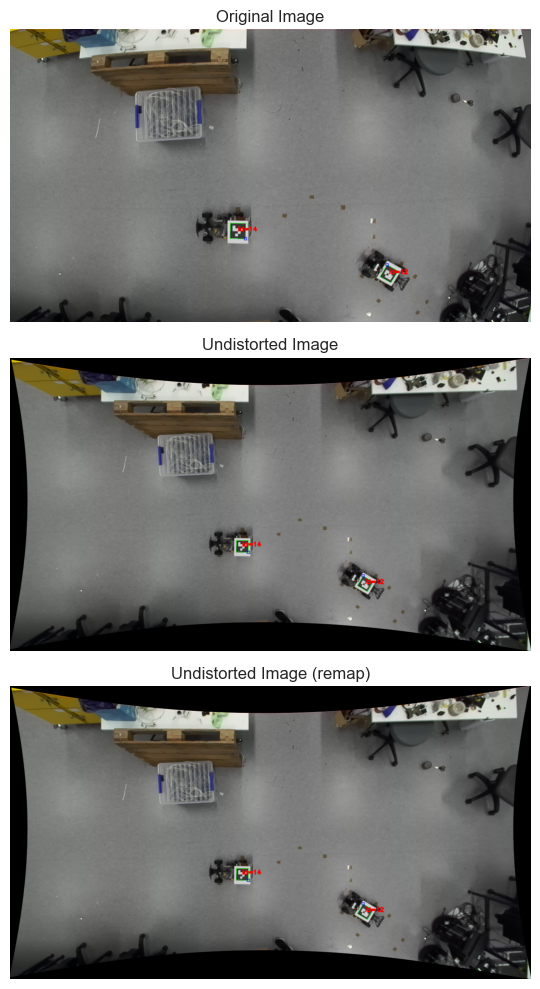

In [8]:
image = cv2.imread(f'{run1_path}/bev/24_09_15_18:50:11/bev/right/1726383014030341577.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

intrinsics = np.loadtxt(f'{run1_path}/bev/24_09_15_18:50:11/bev/right/intrinsics.txt')
dist_coeffs = np.loadtxt(f'{run1_path}/bev/24_09_15_18:50:11/bev/right/dist_coeffs.txt')

new_img_size = (int(image.shape[1] * 1.2), int(image.shape[0] * 1.2))
# not specifying new image size
new_intrinsics, _ = cv2.getOptimalNewCameraMatrix(intrinsics, dist_coeffs, (image.shape[1], image.shape[0]), 1)
undistorted_image = cv2.undistort(image, intrinsics, dist_coeffs, None, new_intrinsics)

# specifying new image size
new_intrinsics2, _ = cv2.getOptimalNewCameraMatrix(intrinsics, dist_coeffs, (image.shape[1], image.shape[0]), 1)
mapx, mapy = cv2.initUndistortRectifyMap(intrinsics, dist_coeffs, None, new_intrinsics, image.shape[:2][::-1], m1type=cv2.CV_32FC1)
undistorted_image2 = cv2.remap(image, mapx, mapy, cv2.INTER_LINEAR)

und_corners, und_ids, _ = cv2.aruco.detectMarkers(undistorted_image, dictionary, parameters=detector_params)
und2_corners, und2_ids, _ = cv2.aruco.detectMarkers(undistorted_image2, dictionary, parameters=detector_params)
corners, ids, _ = cv2.aruco.detectMarkers(image, cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50), parameters=detector_params)

_, rvec_und, tvec_und = cv2.solvePnP(marker_obj_points, und_corners[0], new_intrinsics, None,  flags=cv2.SOLVEPNP_IPPE_SQUARE)
euler_und = conv.get_euler_from_quaternion(*conv.get_quaternion_from_rodrigues(rvec_und), degrees=True)

_, rvec_und2, tvec_und2 = cv2.solvePnP(marker_obj_points, und2_corners[0], new_intrinsics, None,  flags=cv2.SOLVEPNP_IPPE_SQUARE)
euler_und2 = conv.get_euler_from_quaternion(*conv.get_quaternion_from_rodrigues(rvec_und2), degrees=True)

_, rvec, tvec = cv2.solvePnP(marker_obj_points, corners[1], intrinsics, dist_coeffs,  flags=cv2.SOLVEPNP_IPPE_SQUARE)
euler = conv.get_euler_from_quaternion(*conv.get_quaternion_from_rodrigues(rvec), degrees=True)

image_draw = cv2.aruco.drawDetectedMarkers(image.copy(), corners, ids)
und_image_draw = cv2.aruco.drawDetectedMarkers(undistorted_image.copy(), und_corners, und_ids)
und2_image_draw = cv2.aruco.drawDetectedMarkers(undistorted_image2.copy(), und2_corners, und2_ids)

plt.figure(figsize=(6, 10))
plt.subplot(3, 1, 1)
plt.grid(False)
plt.axis('off')
plt.imshow(image_draw)
plt.title("Original Image")
plt.subplot(3, 1, 2)
plt.grid(False)
plt.axis('off')
plt.imshow(und_image_draw)
plt.title("Undistorted Image")
plt.subplot(3, 1, 3)
plt.grid(False)
plt.axis('off')
plt.imshow(und2_image_draw)
plt.title("Undistorted Image (remap)")
plt.tight_layout()

print(intrinsics)
print(new_intrinsics)

tvec, euler, tvec_und, euler_und, tvec_und2, euler_und2

### Generate positive Euler angles following XYZ extrinsic convention

In [9]:
def stabilise_euler_angles(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
  """
  Stabilise the Euler angles by ensuring that the difference 
  between consecutive angles is less than 180 degrees
  """
  def find_closest_equiv_angle(alpha, beta):
    """
    Find the equivalent angle to alpha that is closest to beta
    """
    diff = beta - alpha
    if diff > 180:
      return alpha + 360
    elif diff < -180:
      return alpha - 360
    return alpha
  
  for i, row in df.iterrows():
    if i == 0:
      continue

    for col in cols:
      prev = df.loc[i - 1, col]
      curr = row[col]

      if abs(prev - curr) > 180:
        df.loc[i, col] = find_closest_equiv_angle(curr, prev) 

  for col in cols:
    df.loc[0, col] = find_closest_equiv_angle(df.loc[0, col], df.loc[1, col])  
    
  return df

In [10]:
ego_bev_right_df['roll'], ego_bev_right_df['pitch'], ego_bev_right_df['yaw'] = \
  zip(*ego_bev_right_df.apply(lambda row: conv.get_euler_from_quaternion(*row[['qx','qy','qz','qw']], degrees=True), axis=1))
opp_bev_right_df['roll'], opp_bev_right_df['pitch'], opp_bev_right_df['yaw'] = \
  zip(*opp_bev_right_df.apply(lambda row: conv.get_euler_from_quaternion(*row[['qx','qy','qz','qw']], degrees=True), axis=1))
tracking_df['roll'], tracking_df['pitch'], tracking_df['yaw'] = \
  zip(*tracking_df.apply(lambda row: conv.get_euler_from_quaternion(*row[['qx','qy','qz','qw']], degrees=True), axis=1))

ego_bev_right_df = stabilise_euler_angles(ego_bev_right_df, ['roll', 'pitch', 'yaw'])
opp_bev_right_df = stabilise_euler_angles(opp_bev_right_df, ['roll', 'pitch', 'yaw'])
tracking_df = stabilise_euler_angles(tracking_df, ['roll', 'pitch', 'yaw'])

/tmp/ipykernel_11027/1055967131.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ego_bev_right_df['roll'], ego_bev_right_df['pitch'], ego_bev_right_df['yaw'] = \
/tmp/ipykernel_11027/1055967131.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ego_bev_right_df['roll'], ego_bev_right_df['pitch'], ego_bev_right_df['yaw'] = \
/tmp/ipykernel_11027/1055967131.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [11]:
opp_bev_right_df.describe()

time          qx          qy          qz          qw  \
count  2.320000e+02  232.000000  232.000000  232.000000  232.000000   
mean   1.726385e+18    0.038782   -0.619349    0.005930    0.009344   
std    1.210335e+09    0.036542    0.784641    0.018052    0.010912   
min    1.726385e+18   -0.060707   -0.999955   -0.060834    0.000007   
25%    1.726385e+18    0.018813   -0.998921    0.002675    0.003189   
50%    1.726385e+18    0.046464   -0.997853    0.013191    0.005801   
75%    1.726385e+18    0.067872   -0.996402    0.016774    0.009227   
max    1.726385e+18    0.090683    0.999924    0.041524    0.055963   

               ax          ay          az          tx          ty          tz  \
count  232.000000  232.000000  232.000000  232.000000  232.000000  232.000000   
mean     0.121420   -1.938438    0.018733   -1.253801    0.545278    2.749496   
std      0.114419    2.447446    0.056226    0.658791    0.047325    0.012178   
min     -0.190703   -3.139437   -0.186941   -2.352732    0.434928    2.711685   
25%      0.058817   -3.127212    0.008299   -1.829415    0.510799    2.742953   
50%      0.145317   -3.121439    0.041369   -1.293694    0.554245    2.748782   
75%      0.212583   -3.100187    0.052610   -0.648292    0.588384    2.755511   
max      0.283639    3.138331    0.130404   -0.276688    0.601690    2.796866   

         time (sec)  time_norm (sec)        roll       pitch         yaw  
count  2.320000e+02       232.000000  232.000000  232.000000  232.000000  
mean   1.726385e+09         2.028224 -178.230732   -0.508634 -174.530801  
std    1.210335e+00         1.210335    1.250592    1.579833    2.711537  
min    1.726385e+09        -0.013628 -183.013913   -6.361357 -180.068469  
25%    1.726385e+09         0.963272 -178.786721   -0.906725 -176.602865  
50%    1.726385e+09         2.112060 -178.236831   -0.632981 -174.658806  
75%    1.726385e+09         3.071714 -177.706620   -0.246026 -172.223857  
max    1.726385e+09         4.067951 -172.928282    6.361435 -169.600130

### Sanity checking conversions

In [12]:
rvec = ego_bev_right_df[["ax", "ay", "az"]].values[0]
euler = ego_bev_right_df[["roll", "pitch", "yaw"]].values[0]
quat = ego_bev_right_df[["qx", "qy", "qz", "qw"]].values[0]

print("rvecs")
print(rvec, conv.get_rodrigues_from_euler(*euler, degrees=True), sep="\n")

print("quats")
print(conv.get_quaternion_from_rodrigues(rvec), conv.get_quaternion_from_euler(*euler, degrees=True), sep="\n")

print("rotation matrices")
print(conv.get_rotation_matrix_from_quaternion(*quat), cv2.Rodrigues(rvec)[0], conv.get_rotation_matrix_from_euler(*euler, degrees=True), sep="\n")

print("euler angles")
print(conv.get_euler_from_quaternion(*quat), conv.get_euler_from_rotation_matrix(conv.get_rotation_matrix_from_quaternion(*quat)), sep="\n")

rvecs
[ 3.02389585  0.82590038 -0.0376079 ]
[ 3.02389585  0.82590038 -0.0376079 ]
quats
[ 0.9645916   0.26345371 -0.01199653  0.00335638]
(0.9645916035702194, 0.2634537080875546, -0.011996530972061293, 0.003356376228394645)
rotation matrices
[[ 8.60896454e-01  5.08330999e-01 -2.13750066e-02]
 [ 5.08169940e-01 -8.61161757e-01 -1.27961258e-02]
 [-2.49120056e-02  1.54003519e-04 -9.99689636e-01]]
[[ 8.60896454e-01  5.08330999e-01 -2.13750066e-02]
 [ 5.08169940e-01 -8.61161757e-01 -1.27961258e-02]
 [-2.49120056e-02  1.54003519e-04 -9.99689636e-01]]
[[ 8.60896454e-01  5.08330999e-01 -2.13750066e-02]
 [ 5.08169940e-01 -8.61161757e-01 -1.27961258e-02]
 [-2.49120056e-02  1.54003519e-04 -9.99689636e-01]]
euler angles
(3.1414386022599086, 0.02491458310644168, 0.5332417680518773)
(3.1414386022599086, 0.0249145831064419, 0.5332417680518773)


### Get ground truth position of relative translation between egovehicle camera and opponent back marker

In [13]:
ego_bev_right_df

time        qx        qy        qz        qw        ax  \
0    1726384502785766956  0.964592  0.263454 -0.011997  0.003356  3.023896   
1    1726384502800483308  0.964566  0.263641 -0.010037  0.002180  3.026075   
2    1726384502816710353 -0.965110 -0.261629  0.010488  0.001471 -3.029148   
3    1726384502833403957  0.964547  0.263710 -0.010155  0.001826  3.026696   
4    1726384502850173537  0.964632  0.263393 -0.010325  0.001314  3.027949   
..                   ...       ...       ...       ...       ...       ...   
227  1726384506800429360  0.999781 -0.004812  0.011253  0.016960  3.107437   
228  1726384506817000248  0.999969 -0.004119  0.006350  0.002322  3.136859   
229  1726384506833633838  0.999989 -0.003941  0.001479  0.002188  3.137189   
230  1726384506850566073  0.999981 -0.001412 -0.003560  0.004841  3.131889   
231  1726384506867346276 -0.999832 -0.000054  0.016335  0.008315 -3.124546   

           ay        az        tx        ty        tz    time (sec)  \
0    0.825900 -0.037608  1.336453  1.134517  2.951443  1.726385e+09   
1    0.827106 -0.031487  1.336386  1.134444  2.951163  1.726385e+09   
2   -0.821164  0.032919  1.332434  1.131146  2.942379  1.726385e+09   
3    0.827506 -0.031865  1.334268  1.132506  2.946362  1.726385e+09   
4    0.826783 -0.032411  1.334213  1.132590  2.946340  1.726385e+09   
..        ...       ...       ...       ...       ...           ...   
227 -0.014956  0.034977 -0.727819  0.944493  2.975212  1.726385e+09   
228 -0.012922  0.019919 -0.728368  0.933454  2.939707  1.726385e+09   
229 -0.012363  0.004641 -0.735529  0.931791  2.934375  1.726385e+09   
230 -0.004423 -0.011149 -0.744207  0.932073  2.935254  1.726385e+09   
231 -0.000168  0.051050 -0.744452  0.921681  2.902919  1.726385e+09   

     time_norm (sec)        roll     pitch        yaw  
0          -0.013628  179.991174  1.427500  30.552503  
1           0.001088  180.062233  1.175314  30.574756  
2           0.017316  180.477207  1.115907  30.339913  
3           0.034009  180.105024  1.177652  30.583327  
4           0.050779  180.166432  1.181107  30.546431  
..               ...         ...       ...        ...  
227         4.001034  178.062243 -1.298732  -0.529554  
228         4.017605  179.736895 -0.728721  -0.470386  
229         4.034239  179.749934 -0.170492  -0.451211  
230         4.051171  179.444728  0.407124  -0.163808  
231         4.067951  180.953289  1.871877   0.021719  

[232 rows x 16 columns]

In [14]:
num = 50

ego_top_marker_to_bev_rvec = ego_bev_right_df.iloc[num][["ax", "ay", "az"]].to_numpy()
ego_top_marker_in_bev_frame = ego_bev_right_df.iloc[num][["tx", "ty", "tz"]].to_numpy()

opp_top_marker_to_bev_rvec = opp_bev_right_df.iloc[num][["ax", "ay", "az"]].to_numpy()
opp_top_marker_in_bev_frame = opp_bev_right_df.iloc[num][["tx", "ty", "tz"]].to_numpy()

def get_ego_cam_from_top_marker(rvec, tvec):
  """
  Get the position of the ego camera in the BEV camera frame
  """
  # ego_cam_in_ego_top_marker_frame = np.array([-1, 1, 1])
  ego_cam_in_ego_top_marker_frame = np.array([BEV_TO_CAM_EGO_X, BEV_TO_CAM_EGO_Y, BEV_TO_CAM_EGO_Z]) / 1000
  # rvec = conv.get_rodrigues_from_euler(180,0,20, degrees=True)
  # Figure out whether the rotation should be transposed
  ego_top_marker_to_bev_rot = cv2.Rodrigues(rvec)[0]
  
  print(tvec, rvec, ego_top_marker_to_bev_rot)

  ego_cam_in_ego_top_marker_frame_rot_to_bev = ego_top_marker_to_bev_rot @ ego_cam_in_ego_top_marker_frame
  print(ego_cam_in_ego_top_marker_frame)

  print('p', ego_cam_in_ego_top_marker_frame_rot_to_bev)
  ego_top_marker_in_bev_frame = tvec

  ego_cam_in_bev_frame = ego_top_marker_in_bev_frame + ego_cam_in_ego_top_marker_frame_rot_to_bev
  # print(np.concatenate([ego_top_marker_to_bev_rot, tvec.reshape(3, -1)], axis = -1) @ np.concatenate([ego_cam_in_ego_top_marker_frame, [1]]))
  print(ego_cam_in_bev_frame)

  return ego_cam_in_bev_frame

def get_opp_back_from_top_marker(rvec, tvec):
  """
  Get the position of the opponent back marker in the BEV camera frame
  """
  opp_back_in_opp_top_marker_frame = np.array([BEV_TO_BACK_OPP_X, BEV_TO_BACK_OPP_Y, BEV_TO_BACK_OPP_Z]) / 1000
  opp_top_marker_to_bev_rot = cv2.Rodrigues(rvec)[0]

  opp_back_in_opp_top_marker_frame_rot_to_bev = opp_top_marker_to_bev_rot @ opp_back_in_opp_top_marker_frame
  opp_top_marker_in_bev_frame = tvec

  opp_back_in_bev_frame = opp_top_marker_in_bev_frame + opp_back_in_opp_top_marker_frame_rot_to_bev
  return opp_back_in_bev_frame

def rotate_bev_frame_to_ego_cam_frame(rvec, tvec):
  """
  Rotate the pose vector in the BEV frame to the ego camera frame
  """
  roll, pitch, yaw = conv.get_euler_from_quaternion(*conv.get_quaternion_from_rodrigues(rvec))

  # Sometimes the marker may be detected as tilted in the pitch axis. 
  # Here we assume that the camera is always parallel to the ground
  bev_to_ego_top_marker_rot = cv2.Rodrigues(conv.get_rodrigues_from_euler(roll, 0, yaw))[0].T

  # This assumes that the camera and the top marker are aligned by 90 degree rotations
  # bev_to_ego_top_marker_rot = cv2.Rodrigues(rvec)[0].T
  
  return conv.get_rotation_matrix_from_quaternion(*EGO_TOP_MARKER_TO_EGO_CAM_QUAT).T @ bev_to_ego_top_marker_rot @ tvec

# Get position of ego camera in BEV frame
ego_cam_in_bev_frame = get_ego_cam_from_top_marker(ego_top_marker_to_bev_rvec, ego_top_marker_in_bev_frame)
# Get position of opponent back marker in BEV frame
opp_back_in_bev_frame = get_opp_back_from_top_marker(opp_top_marker_to_bev_rvec, opp_top_marker_in_bev_frame)

# Get the relative pose of the opponent back marker in the BEV camera frame
ground_truth_rel_pose_bev_frame = opp_back_in_bev_frame - ego_cam_in_bev_frame
# Convert the relative pose to the ego camera frame
print(ground_truth_rel_pose_bev_frame)
ground_truth_rel_pose_ego_cam_frame = rotate_bev_frame_to_ego_cam_frame(ego_top_marker_to_bev_rvec, ground_truth_rel_pose_bev_frame)

ground_truth_rel_pose_ego_cam_frame

[1.06435639 1.01884175 2.94146435] [ 3.08105099  0.58087463 -0.03751587] [[ 0.93107606  0.36413714 -0.02239448]
 [ 0.36399264 -0.93134413 -0.01036677]
 [-0.02463189  0.00150082 -0.99969546]]
[-0.1848 -0.0395  0.0125]
p [-0.1867262  -0.03060733 -0.0080035 ]
[0.87763019 0.98823442 2.93346085]
[-1.35895699 -0.38180232 -0.04800984]


array([-0.1392775 , -0.0478008 ,  1.40469175])

In [15]:
ego_bev_right_df["ty"].rolling(window=20, min_periods=1, center=True).mean().iloc[30:]

30     1.087106
31     1.084142
32     1.081227
33     1.077909
34     1.074624
         ...   
227    0.930331
228    0.931504
229    0.932029
230    0.932175
231    0.932424
Name: ty, Length: 202, dtype: float64

In [16]:
from scipy.signal import savgol_filter

### apply exponential smoothing to the tracking data
# ego_bev_df['ty'].ewm(span=5).mean().plot()

def apply_rolling_mean(df: pd.DataFrame, src: str, dest: str, window=20, min_periods=1, center=True):
  df.loc[:, dest] = df[src].rolling(window=window, min_periods=min_periods, center=center).mean()

def apply_savgol_filter(df: pd.DataFrame, src: str, dest: str, window=20, polyorder=5):
  df.loc[:, dest] = savgol_filter(df[src], window, polyorder)

columns = ["tx", "ty", "tz", "roll", "pitch", "yaw"]

for col in columns:
  apply_rolling_mean(ego_bev_right_df, col, f"{col} (rolling)")
  apply_savgol_filter(ego_bev_right_df, col, f"{col} (savgol)", polyorder=2)

  apply_rolling_mean(opp_bev_right_df, col, f"{col} (rolling)")
  apply_savgol_filter(opp_bev_right_df, col, f"{col} (savgol)", polyorder=2)

stabilise_euler_angles(ego_bev_right_df, ["roll (rolling)", "pitch (rolling)", "yaw (rolling)"])
stabilise_euler_angles(opp_bev_right_df, ["roll (rolling)", "pitch (rolling)", "yaw (rolling)"])

stabilise_euler_angles(ego_bev_right_df, ["roll (savgol)", "pitch (savgol)", "yaw (savgol)"])
stabilise_euler_angles(opp_bev_right_df, ["roll (savgol)", "pitch (savgol)", "yaw (savgol)"])

ego_bev_right_df["ax (rolling)"], ego_bev_right_df["ay (rolling)"], ego_bev_right_df["az (rolling)"] = \
  zip(*ego_bev_right_df.apply(lambda row: conv.get_rodrigues_from_euler(*row[["roll (rolling)", "pitch (rolling)", "yaw (rolling)"]], degrees=True), axis=1))
opp_bev_right_df["ax (rolling)"], opp_bev_right_df["ay (rolling)"], opp_bev_right_df["az (rolling)"] = \
  zip(*opp_bev_right_df.apply(lambda row: conv.get_rodrigues_from_euler(*row[["roll (rolling)", "pitch (rolling)", "yaw (rolling)"]], degrees=True), axis=1))

ego_bev_right_df["ax (savgol)"], ego_bev_right_df["ay (savgol)"], ego_bev_right_df["az (savgol)"] = \
  zip(*ego_bev_right_df.apply(lambda row: conv.get_rodrigues_from_euler(*row[["roll (savgol)", "pitch (savgol)", "yaw (savgol)"]], degrees=True), axis=1))
opp_bev_right_df["ax (savgol)"], opp_bev_right_df["ay (savgol)"], opp_bev_right_df["az (savgol)"] = \
  zip(*opp_bev_right_df.apply(lambda row: conv.get_rodrigues_from_euler(*row[["roll (savgol)", "pitch (savgol)", "yaw (savgol)"]], degrees=True), axis=1))


/tmp/ipykernel_11027/2964804804.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, dest] = df[src].rolling(window=window, min_periods=min_periods, center=center).mean()
/tmp/ipykernel_11027/2964804804.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, dest] = savgol_filter(df[src], window, polyorder)
/tmp/ipykernel_11027/2964804804.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



In [17]:
ego_bev_right_df

time        qx        qy        qz        qw        ax  \
0    1726384502785766956  0.964592  0.263454 -0.011997  0.003356  3.023896   
1    1726384502800483308  0.964566  0.263641 -0.010037  0.002180  3.026075   
2    1726384502816710353 -0.965110 -0.261629  0.010488  0.001471 -3.029148   
3    1726384502833403957  0.964547  0.263710 -0.010155  0.001826  3.026696   
4    1726384502850173537  0.964632  0.263393 -0.010325  0.001314  3.027949   
..                   ...       ...       ...       ...       ...       ...   
227  1726384506800429360  0.999781 -0.004812  0.011253  0.016960  3.107437   
228  1726384506817000248  0.999969 -0.004119  0.006350  0.002322  3.136859   
229  1726384506833633838  0.999989 -0.003941  0.001479  0.002188  3.137189   
230  1726384506850566073  0.999981 -0.001412 -0.003560  0.004841  3.131889   
231  1726384506867346276 -0.999832 -0.000054  0.016335  0.008315 -3.124546   

           ay        az        tx        ty  ...  pitch (rolling)  \
0    0.825900 -0.037608  1.336453  1.134517  ...         1.111376   
1    0.827106 -0.031487  1.336386  1.134444  ...         1.082727   
2   -0.821164  0.032919  1.332434  1.131146  ...         1.047747   
3    0.827506 -0.031865  1.334268  1.132506  ...         1.041954   
4    0.826783 -0.032411  1.334213  1.132590  ...         1.005936   
..        ...       ...       ...       ...  ...              ...   
227 -0.014956  0.034977 -0.727819  0.944493  ...         0.465838   
228 -0.012922  0.019919 -0.728368  0.933454  ...         0.280040   
229 -0.012363  0.004641 -0.735529  0.931791  ...         0.102787   
230 -0.004423 -0.011149 -0.744207  0.932073  ...         0.069638   
231 -0.000168  0.051050 -0.744452  0.921681  ...        -0.009885   

     pitch (savgol)  yaw (rolling)  yaw (savgol)  ax (rolling)  ay (rolling)  \
0          1.301308      30.527610     30.506533      3.027637      0.826180   
1          1.255316      30.515679     30.537936      3.026300      0.825503   
2          1.211231      30.493275     30.558067      3.026264      0.824863   
3          1.169051      30.462390     30.566926      3.025523      0.823801   
4          1.128779      30.422062     30.564512      3.025995      0.822785   
..              ...            ...           ...           ...           ...   
227       -0.171112      -0.377199     -0.226370     -3.136776      0.010356   
228       -0.125509      -0.328252     -0.238085     -3.140432      0.009000   
229       -0.041999      -0.283987     -0.259240      3.141042     -0.007784   
230        0.079417      -0.303423     -0.289834      3.140532     -0.008315   
231        0.238740      -0.319483     -0.329868      3.139534     -0.008753   

     az (rolling)  ax (savgol)  ay (savgol)  az (savgol)  
0       -0.030219    -3.030644    -0.826318     0.037020  
1       -0.028758     3.029170     0.826843    -0.035055  
2       -0.027672     3.027739     0.827055    -0.033213  
3       -0.027073     3.026545     0.827005    -0.031497  
4       -0.026131     3.025585     0.826696    -0.029906  
..            ...          ...          ...          ...  
227      0.012727     3.139502    -0.006207     0.004682  
228      0.007670     3.136588    -0.006525     0.003419  
229     -0.002820     3.133466    -0.007094     0.001120  
230     -0.001913     3.130132    -0.007905    -0.002215  
231      0.000262     3.126586    -0.008951    -0.006581  

[232 rows x 34 columns]

In [18]:
opp_bev_right_df

time        qx        qy        qz        qw        ax  \
0    1726384502785766956 -0.013008  0.999109 -0.027805  0.028951 -0.040130   
1    1726384502800483308 -0.009940  0.999338 -0.027512  0.021649 -0.030804   
2    1726384502816710353 -0.012566  0.998451 -0.038398  0.038255 -0.038543   
3    1726384502833403957 -0.012334  0.999357 -0.026198  0.021143 -0.038234   
4    1726384502850173537 -0.012045  0.999115 -0.031599  0.025011 -0.037251   
..                   ...       ...       ...       ...       ...       ...   
227  1726384506800429360  0.088658 -0.995955  0.013792  0.004781  0.277684   
228  1726384506817000248  0.090683 -0.995822  0.008150  0.006933  0.283639   
229  1726384506833633838  0.087623 -0.996069  0.010871  0.007100  0.274038   
230  1726384506850566073  0.087018 -0.996123  0.011241  0.006397  0.272267   
231  1726384506867346276  0.082500 -0.996384  0.001147  0.020296  0.255886   

           ay        az        tx        ty  ...  pitch (rolling)  \
0    3.082228 -0.085779 -0.277587  0.592504  ...         2.989340   
1    3.096965 -0.085260 -0.276815  0.591120  ...         2.743686   
2    3.062558 -0.117780 -0.277681  0.592510  ...         2.725522   
3    3.098003 -0.081215 -0.277562  0.592435  ...         2.134924   
4    3.089796 -0.097720 -0.277634  0.592494  ...         2.215408   
..        ...       ...       ...       ...  ...              ...   
227 -3.119398  0.043197 -2.328858  0.442226  ...        -0.810198   
228 -3.114736  0.025491 -2.330631  0.440157  ...        -0.831492   
229 -3.115178  0.033998 -2.345660  0.440373  ...        -0.848137   
230 -3.116731  0.035172 -2.352732  0.438761  ...        -0.864110   
231 -3.090420  0.003558 -2.346803  0.434928  ...        -0.892585   

     pitch (savgol)  yaw (rolling)  yaw (savgol)  ax (rolling)  ay (rolling)  \
0          4.350213    -178.529382   -178.306570     -0.037199      3.087089   
1          3.821047    -178.585622   -178.402128     -0.035986      3.091491   
2          3.337827    -178.604704   -178.489128     -0.035586      3.091966   
3          2.900551    -178.717301   -178.567567     -0.033210      3.102525   
4          2.509221    -178.687146   -178.637447     -0.033973      3.101133   
..              ...            ...           ...           ...           ...   
227       -0.937970    -170.199386   -170.076347      0.267606     -3.117957   
228       -1.048875    -170.163426   -170.049640      0.268546     -3.117458   
229       -1.172111    -170.121928   -170.025025      0.269647     -3.117042   
230       -1.307680    -170.115462   -170.002501      0.269799     -3.116732   
231       -1.455580    -170.092782   -169.982069      0.270375     -3.116163   

     az (rolling)  ax (savgol)  ay (savgol)  az (savgol)  
0       -0.091741    -0.041137     3.062537    -0.106844  
1       -0.089854    -0.039357     3.072024    -0.102956  
2       -0.085866    -0.037704     3.080697    -0.098927  
3       -0.080918    -0.036186     3.088557    -0.094767  
4       -0.079865    -0.034810     3.095602    -0.090483  
..            ...          ...          ...          ...  
227      0.041976     0.270740    -3.115237     0.036601  
228      0.040730     0.271282    -3.113083     0.032964  
229      0.039859     0.271736    -3.110697     0.028962  
230      0.039456     0.272100    -3.108077     0.024598  
231      0.038893     0.272372    -3.105223     0.019872  

[232 rows x 34 columns]

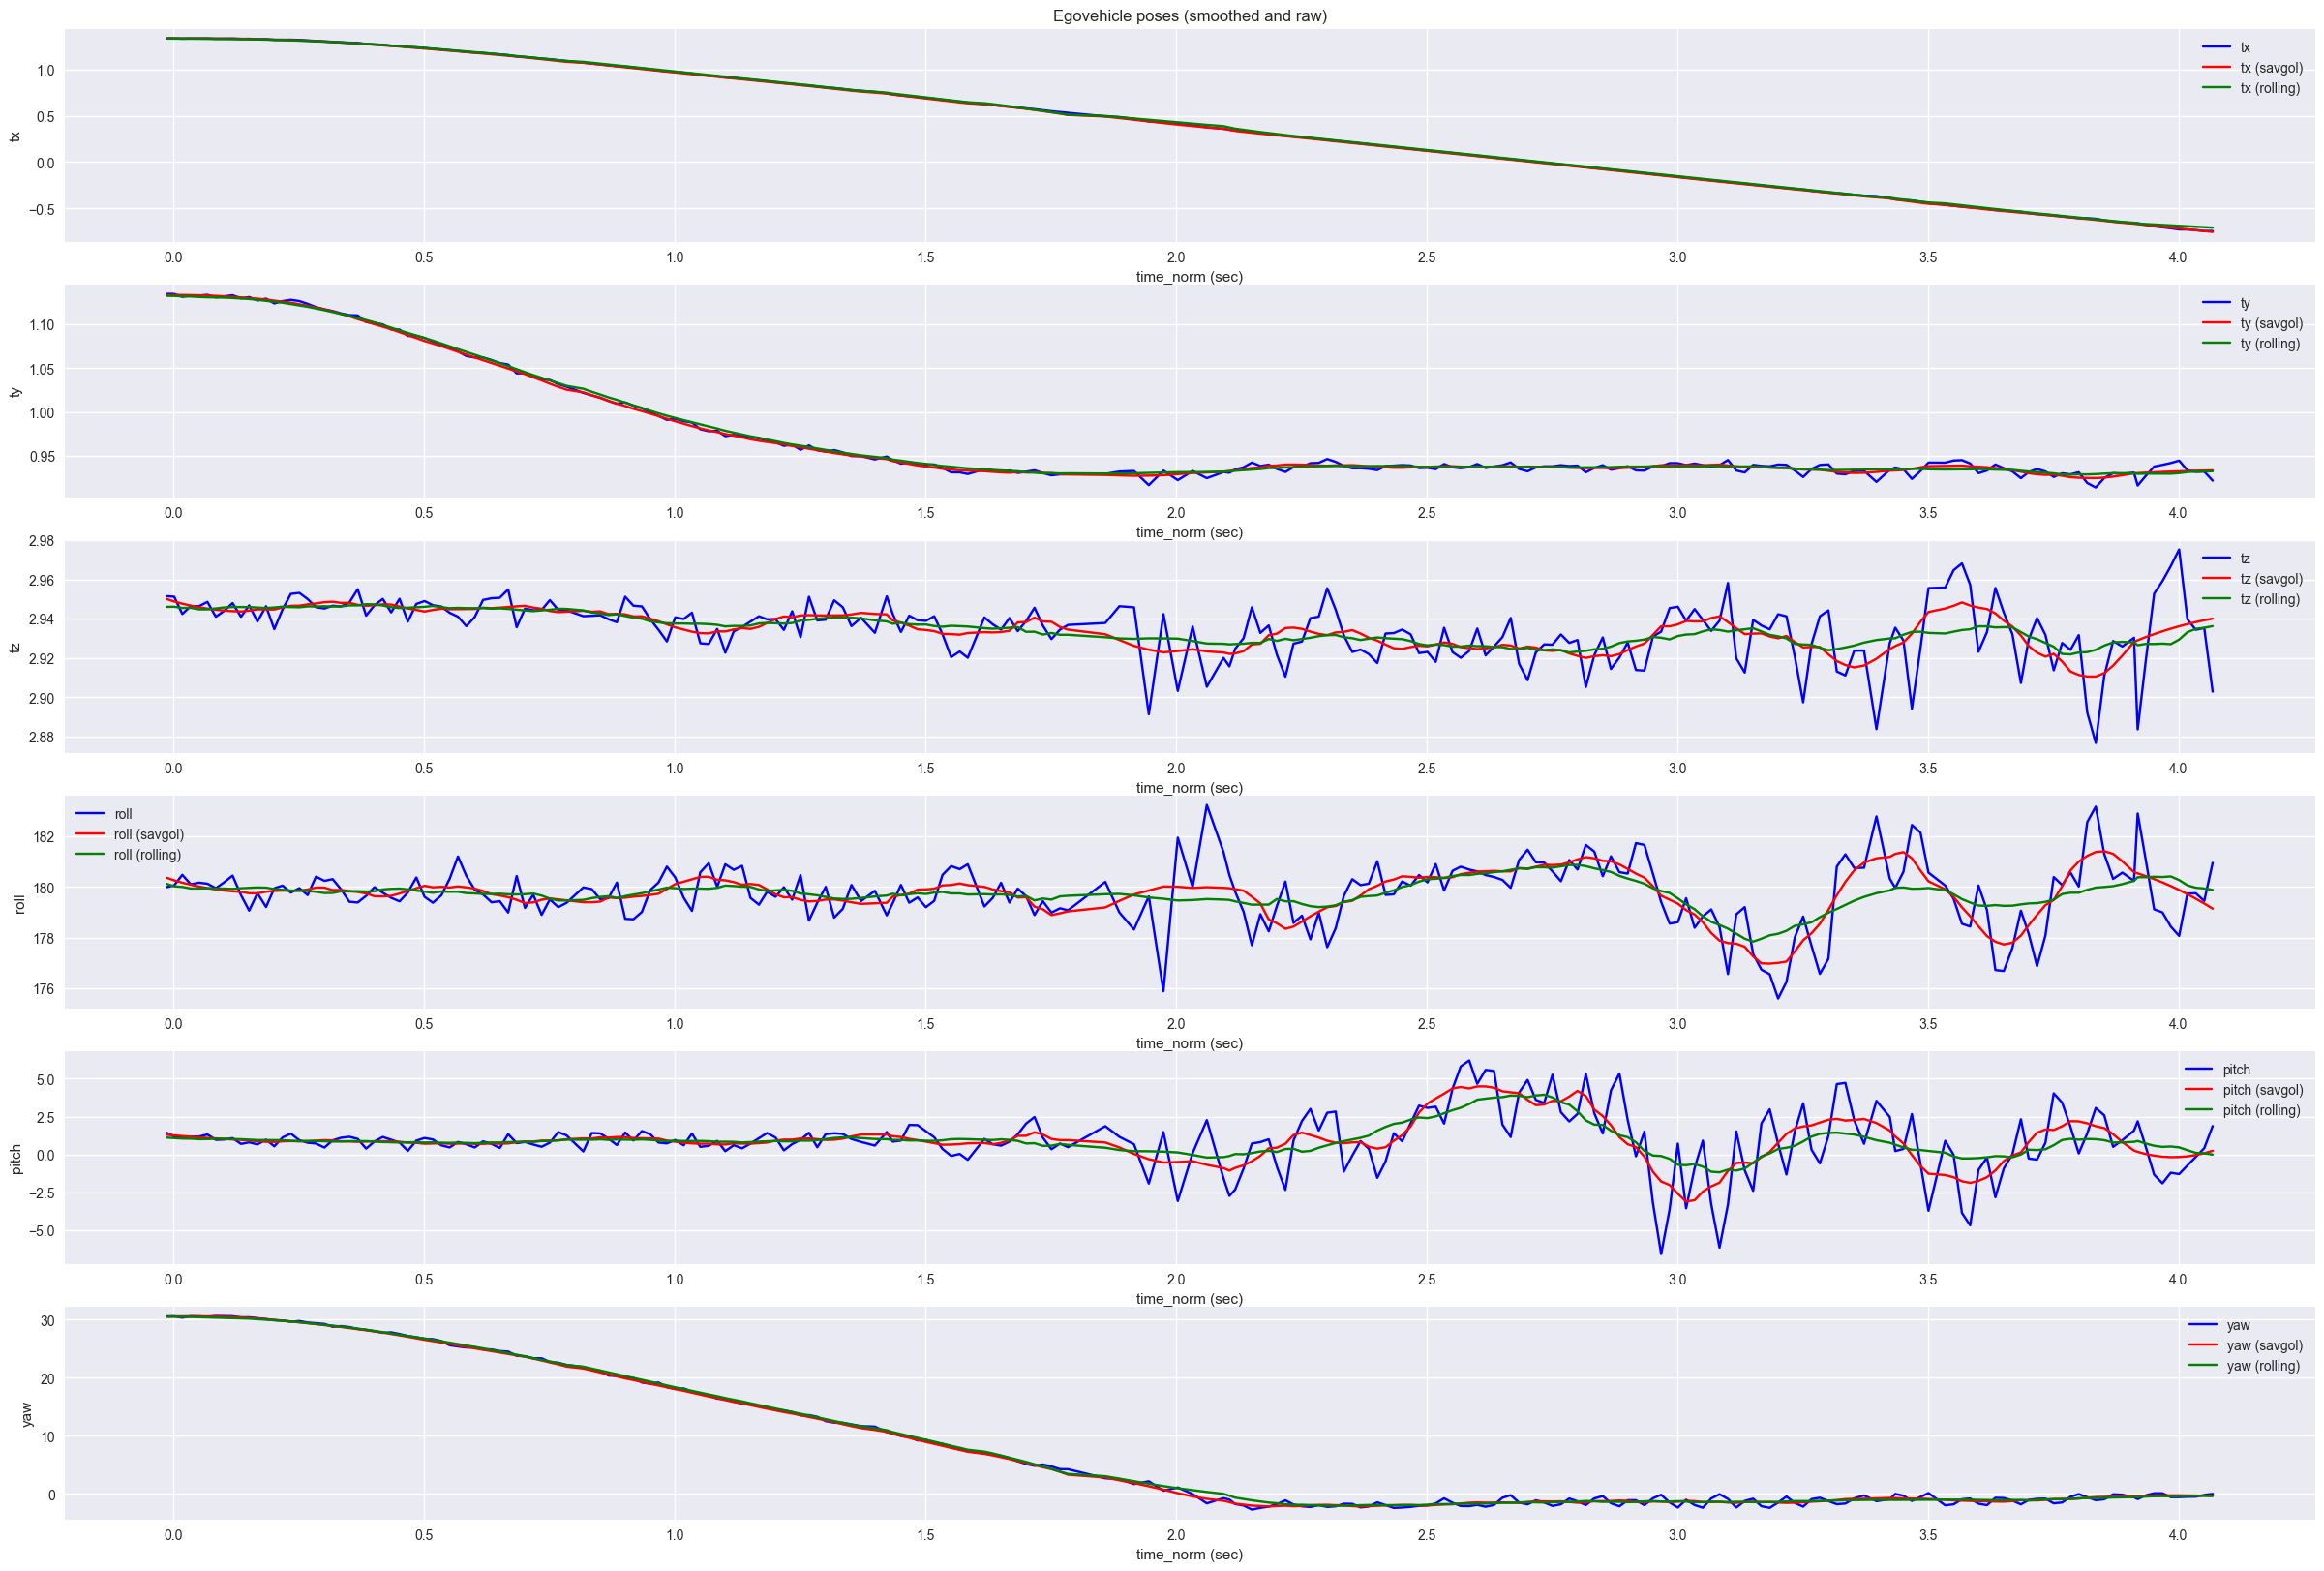

In [19]:
# plot the x and y positions
def plot_smoothed_data(df: pd.DataFrame, x_col: str, y_col: str):
  sns.lineplot(data=df, x=x_col, y=y_col, label=y_col, color='blue')
  sns.lineplot(data=df, x=x_col, y=f"{y_col} (savgol)", label=f"{y_col} (savgol)", color='red')
  sns.lineplot(data=df, x=x_col, y=f"{y_col} (rolling)", label=f"{y_col} (rolling)", color='green')

def plot_all_smoothed_poses(df: pd.DataFrame, columns: list[str], x_col: str):
  fig = plt.figure(figsize=(30, 20))
  for i, col in enumerate(columns):
    plt.subplot(len(columns), 1, i + 1)
    if i == 0:
      plt.title("Egovehicle poses (smoothed and raw)")
    plot_smoothed_data(df, x_col, col)

plot_all_smoothed_poses(ego_bev_right_df, ["tx", "ty", "tz", "roll", "pitch", "yaw"], "time_norm (sec)")

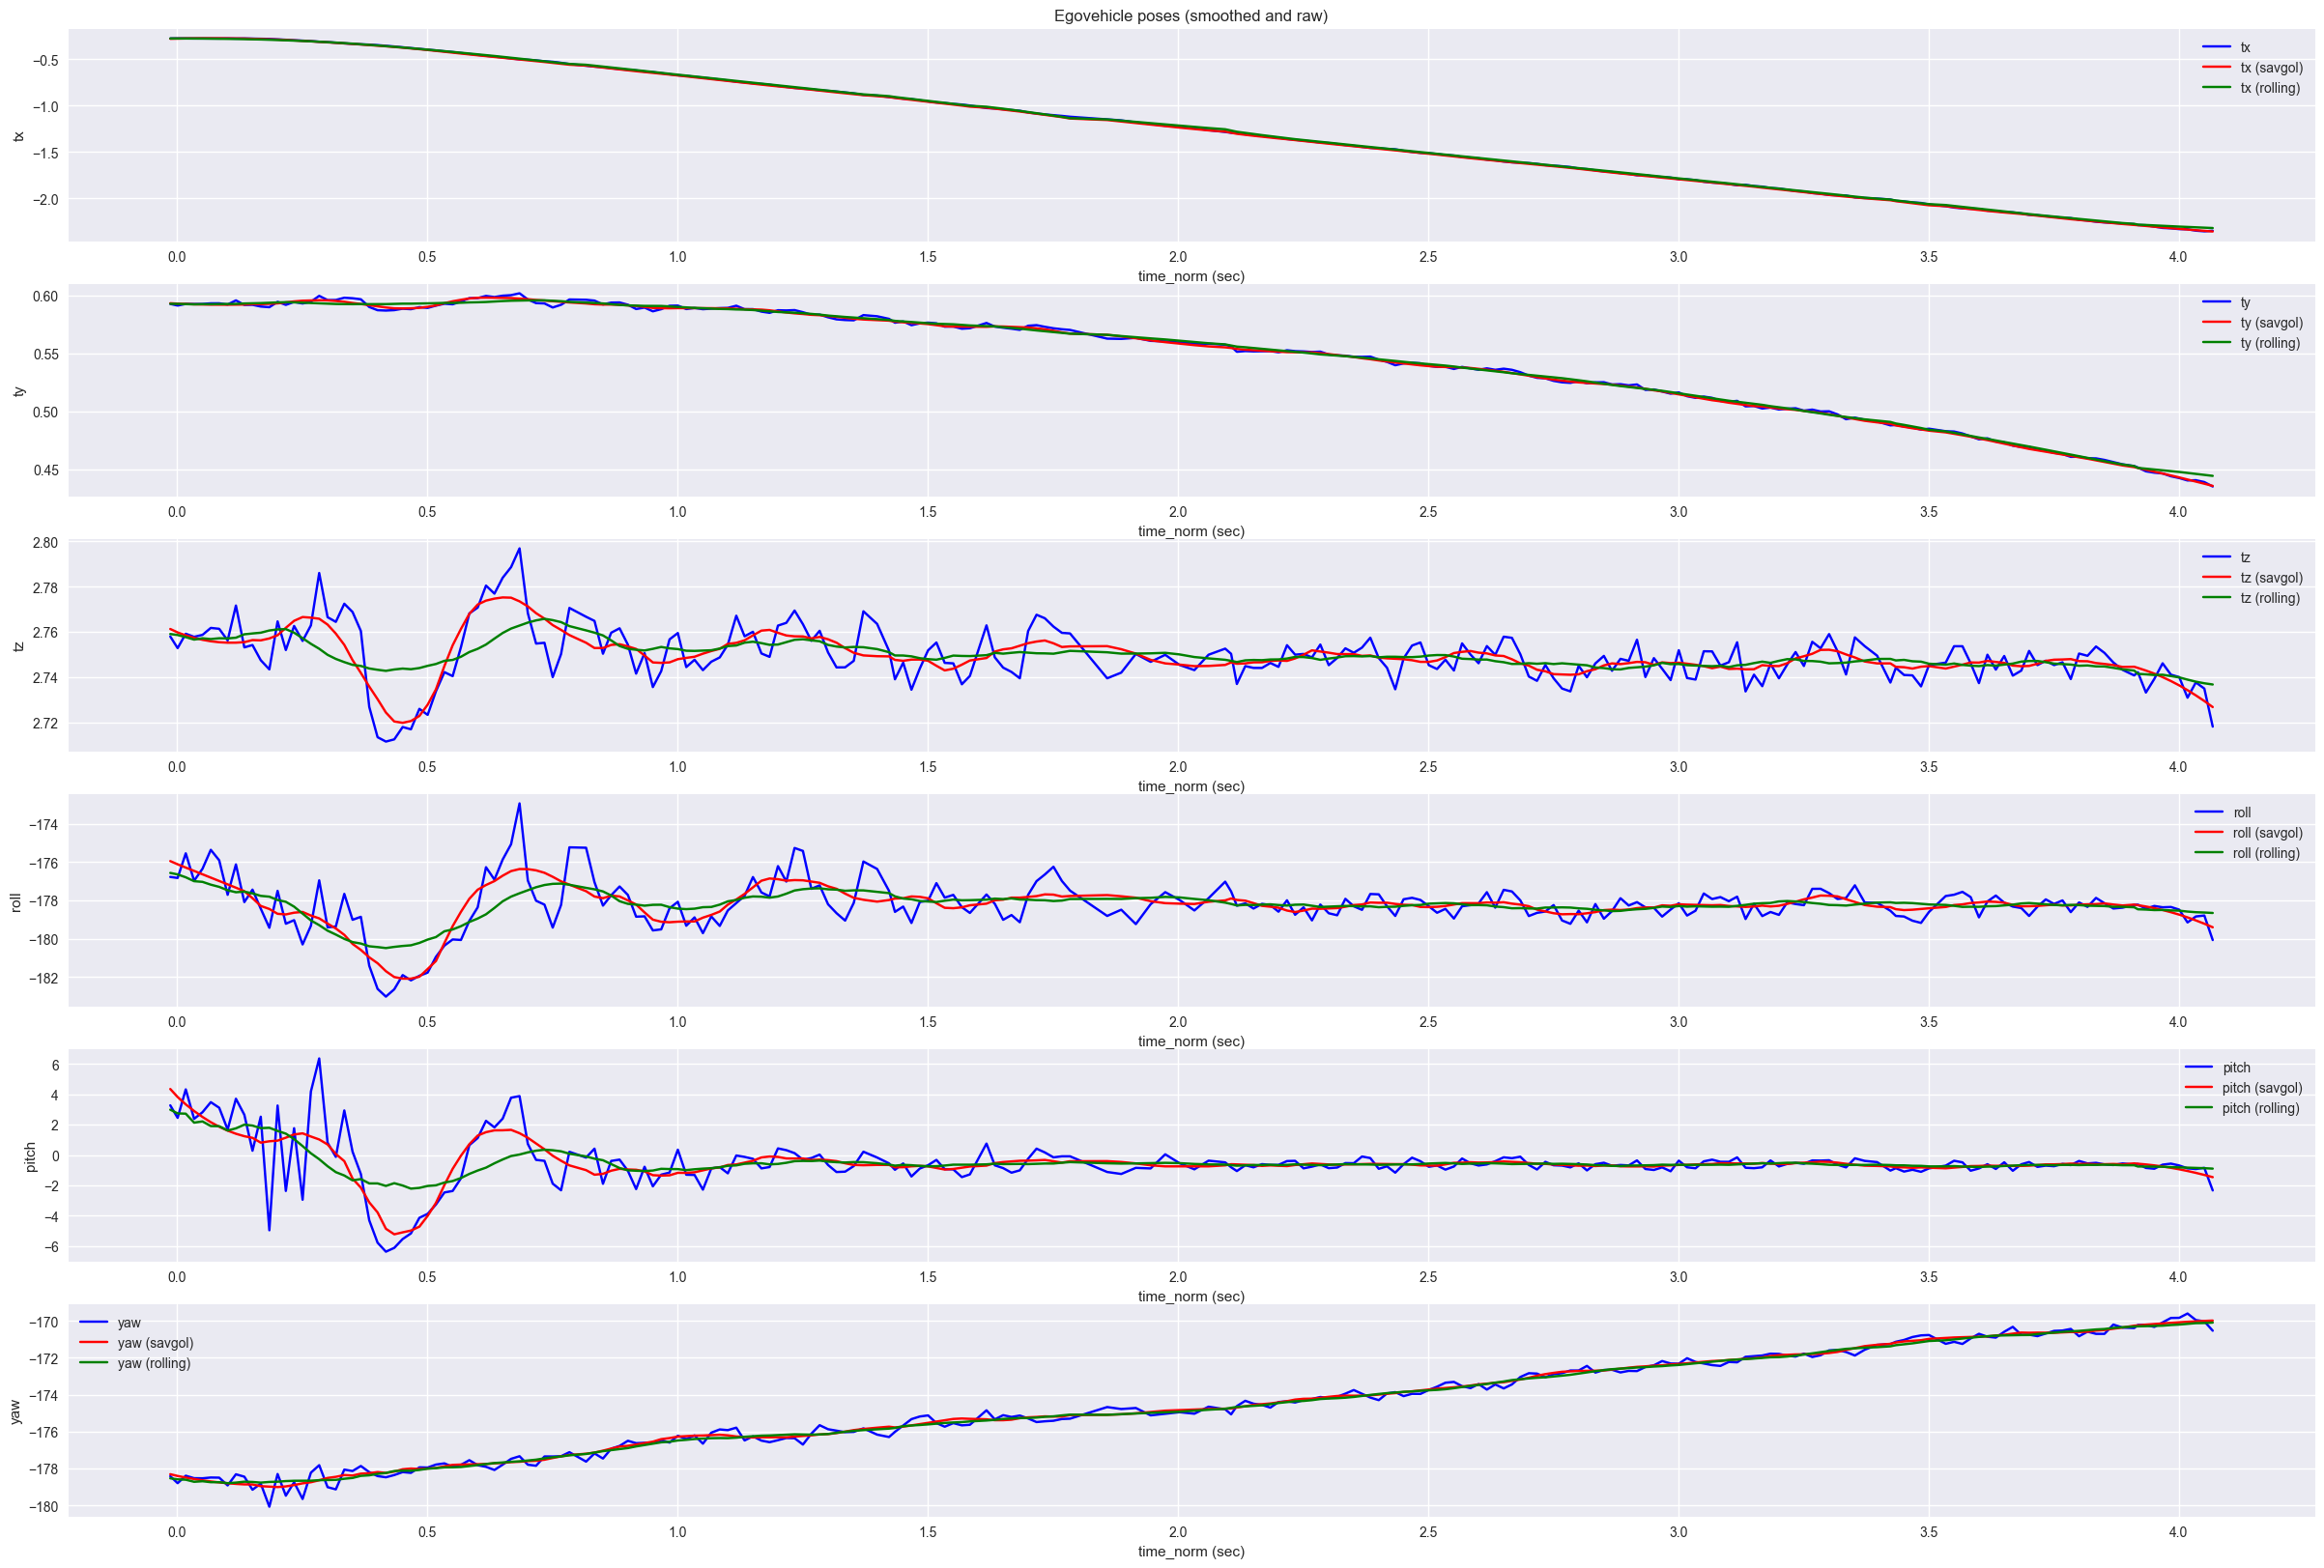

In [20]:
plot_all_smoothed_poses(opp_bev_right_df, ["tx", "ty", "tz", "roll", "pitch", "yaw"], "time_norm (sec)")

In [21]:
def compute_relative_pose(ego_bev_df: pd.DataFrame, opp_bev_df: pd.DataFrame, smoothing=None):
  rel_poses = pd.DataFrame(columns=["time (sec)", "time_norm (sec)", "rel_x", "rel_y", "rel_z", "rel_roll", "rel_pitch", "rel_yaw"])

  for i in range(len(ego_bev_df)):
    if smoothing == "savgol":
      ego_top_marker_to_bev_rvec = ego_bev_df.iloc[i][["ax (savgol)", "ay (savgol)", "az (savgol)"]].to_numpy()
      ego_top_marker_in_bev_frame = ego_bev_df.iloc[i][["tx (savgol)", "ty (savgol)", "tz (savgol)"]].to_numpy()

      opp_top_marker_to_bev_rvec = opp_bev_df.iloc[i][["ax (savgol)", "ay (savgol)", "az (savgol)"]].to_numpy()
      opp_top_marker_in_bev_frame = opp_bev_df.iloc[i][["tx (savgol)", "ty (savgol)", "tz (savgol)"]].to_numpy()
    elif smoothing == "rolling":
      ego_top_marker_to_bev_rvec = ego_bev_df.iloc[i][["ax (rolling)", "ay (rolling)", "az (rolling)"]].to_numpy()
      ego_top_marker_in_bev_frame = ego_bev_df.iloc[i][["tx (rolling)", "ty (rolling)", "tz (rolling)"]].to_numpy()

      opp_top_marker_to_bev_rvec = opp_bev_df.iloc[i][["ax (rolling)", "ay (rolling)", "az (rolling)"]].to_numpy()
      opp_top_marker_in_bev_frame = opp_bev_df.iloc[i][["tx (rolling)", "ty (rolling)", "tz (rolling)"]].to_numpy()
    else:
      ego_top_marker_to_bev_rvec = ego_bev_df.iloc[i][["ax", "ay", "az"]].to_numpy()
      ego_top_marker_in_bev_frame = ego_bev_df.iloc[i][["tx", "ty", "tz"]].to_numpy()

      opp_top_marker_to_bev_rvec = opp_bev_df.iloc[i][["ax", "ay", "az"]].to_numpy()
      opp_top_marker_in_bev_frame = opp_bev_df.iloc[i][["tx", "ty", "tz"]].to_numpy()

    ego_cam_in_bev_frame = get_ego_cam_from_top_marker(ego_top_marker_to_bev_rvec, ego_top_marker_in_bev_frame)
    opp_back_in_bev_frame = get_opp_back_from_top_marker(opp_top_marker_to_bev_rvec, opp_top_marker_in_bev_frame)

    ground_truth_rel_pose_bev_frame = opp_back_in_bev_frame - ego_cam_in_bev_frame
    ground_truth_rel_pose_ego_cam_frame = rotate_bev_frame_to_ego_cam_frame(ego_top_marker_to_bev_rvec, ground_truth_rel_pose_bev_frame)

    rel_poses = pd.concat([rel_poses, pd.DataFrame([{
      "time (sec)": ego_bev_df.loc[i, "time (sec)"],
      "time_norm (sec)": ego_bev_df.loc[i, "time_norm (sec)"],
      "rel_x": ground_truth_rel_pose_ego_cam_frame[0],
      "rel_y": ground_truth_rel_pose_ego_cam_frame[1],
      "rel_z": ground_truth_rel_pose_ego_cam_frame[2],
    }])])

  return rel_poses.reset_index(drop=True)

rel_pose_ground_truth_df = compute_relative_pose(ego_bev_right_df, opp_bev_right_df)

[1.33645267 1.13451667 2.95144333] [ 3.02389585  0.82590038 -0.0376079 ] [[ 8.60896454e-01  5.08330999e-01 -2.13750066e-02]
 [ 5.08169940e-01 -8.61161757e-01 -1.27961258e-02]
 [-2.49120056e-02  1.54003519e-04 -9.99689636e-01]]
[-0.1848 -0.0395  0.0125]
p [-0.17943993 -0.06005387 -0.00789846]
[1.15701275 1.07446281 2.94354487]
[1.33638598 1.13444428 2.95116312] [ 3.02607481  0.82710581 -0.03148733] [[ 0.86078508  0.50864266 -0.01821233]
 [ 0.50855512 -0.86097704 -0.00949834]
 [-0.02051166 -0.00108594 -0.99978902]]
[-0.1848 -0.0395  0.0125]
p [-0.17939212 -0.06009112 -0.00866391]
[1.15699385 1.07435315 2.9424992 ]
[1.33243364 1.13114564 2.94237866] [-3.0291477  -0.82116396  0.03291904] [[ 0.8628802   0.50497144 -0.0210143 ]
 [ 0.50503315 -0.86309588 -0.002649  ]
 [-0.01947503 -0.00832715 -0.99977567]]
[-0.1848 -0.0395  0.0125]
p [-0.17966931 -0.05927095 -0.00856929]
[1.15276433 1.07187469 2.93380937]
[1.33426785 1.13250631 2.94636247] [ 3.02669552  0.82750623 -0.03186467] [[ 0.86070828  

<AxesSubplot: xlabel='time_norm (sec)', ylabel='rel_z'>

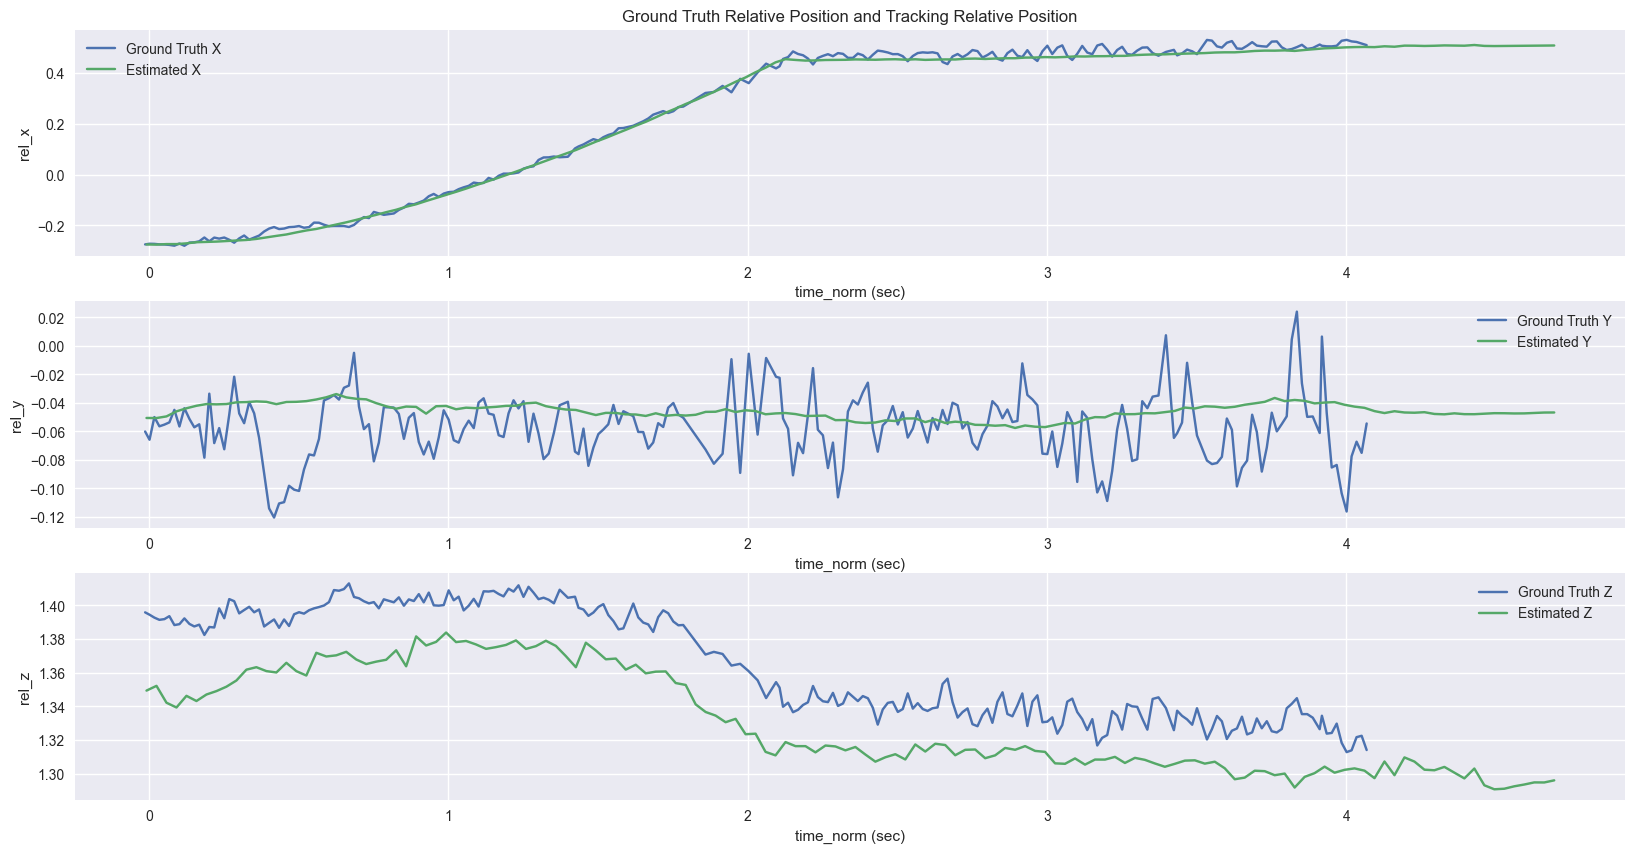

In [23]:
# plot the x and y positions
plt.figure(figsize=(20, 10))

ax = plt.subplot(3, 1, 1)
plt.title("Ground Truth Relative Position and Tracking Relative Position")
# ax.set_ylim(0.4, 0.6)

sns.lineplot(x="time_norm (sec)", y="rel_x", data=rel_pose_ground_truth_df, label="Ground Truth X")
sns.lineplot(x="time_norm (sec)", y="tx", data=tracking_df, label="Estimated X")

ax = plt.subplot(3, 1, 2)
# ax.set_ylim(-0.5, 0.5)
sns.lineplot(x="time_norm (sec)", y="rel_y", data=rel_pose_ground_truth_df, label="Ground Truth Y")
sns.lineplot(x="time_norm (sec)", y="ty", data=tracking_df, label="Estimated Y")

plt.subplot(3, 1, 3)
sns.lineplot(x="time_norm (sec)", y="rel_z", data=rel_pose_ground_truth_df, label="Ground Truth Z")
sns.lineplot(x="time_norm (sec)", y="tz", data=tracking_df, label="Estimated Z")

In [62]:
from numpy.polynomial.polynomial import Polynomial

degree = 10
CONFIDENCE_INTERVAL = 0.95

def fit_model(df: pd.DataFrame, x_col: str, y_col: str, degree=1, confidence_interval=0.95):
  model: Polynomial = Polynomial.fit(df[x_col], df[y_col], degree)
  preds = model(df[x_col])
  residuals = df[y_col] - preds
  se = np.sqrt(sum(residuals ** 2) / (len(residuals) - degree - 1))
  z_score = stats.norm.ppf(1 - (1 - confidence_interval) / 2)
  confidence = z_score * se

  # get R-squared value
  ss_res = sum(residuals ** 2)
  ss_tot = sum((df[y_col] - np.mean(df[y_col])) ** 2)
  r_squared = 1 - (ss_res / ss_tot)

  return model, residuals, confidence, r_squared

tx_model, _, tx_confidence, tx_r2 = fit_model(ego_bev_right_df, "time_norm (sec)", "tx", degree, CONFIDENCE_INTERVAL)
ty_model, _, ty_confidence, ty_r2 = fit_model(ego_bev_right_df, "time_norm (sec)", "ty", degree, CONFIDENCE_INTERVAL)
tz_model, _, tz_confidence, tz_r2 = fit_model(ego_bev_right_df, "time_norm (sec)", "tz", degree, CONFIDENCE_INTERVAL)

tx_rolling_model, _, tx_rolling_confidence, tx_rolling_r2 = fit_model(ego_bev_right_df, "time_norm (sec)", "tx (rolling)", degree, CONFIDENCE_INTERVAL)
ty_rolling_model, _, ty_rolling_confidence, ty_rolling_r2 = fit_model(ego_bev_right_df, "time_norm (sec)", "ty (rolling)", degree, CONFIDENCE_INTERVAL)
tz_rolling_model, _, tz_rolling_confidence, tz_rolling_r2 = fit_model(ego_bev_right_df, "time_norm (sec)", "tz (rolling)", degree, CONFIDENCE_INTERVAL)

pitch_rolling_model, _, pitch_rolling_confidence, pitch_rolling_r2 = fit_model(ego_bev_right_df, "time_norm (sec)", "pitch (rolling)", degree, CONFIDENCE_INTERVAL)
roll_rolling_model, _, roll_rolling_confidence, roll_rolling_r2 = fit_model(ego_bev_right_df, "time_norm (sec)", "roll (rolling)", degree, CONFIDENCE_INTERVAL)
yaw_rolling_model, _, yaw_rolling_confidence, yaw_rolling_r2 = fit_model(ego_bev_right_df, "time_norm (sec)", "yaw (rolling)", degree, CONFIDENCE_INTERVAL)

rel_x_model, _, rel_x_confidence, rel_x_r2 = fit_model(rel_pose_ground_truth_df, "time_norm (sec)", "rel_x", degree, CONFIDENCE_INTERVAL)
rel_y_model, _, rel_y_confidence, rel_y_r2 = fit_model(rel_pose_ground_truth_df, "time_norm (sec)", "rel_y", 1, CONFIDENCE_INTERVAL)
rel_z_model, _, rel_z_confidence, rel_z_r2 = fit_model(rel_pose_ground_truth_df, "time_norm (sec)", "rel_z", degree, CONFIDENCE_INTERVAL)

In [25]:
z_tx: pd.Series = stats.zscore(ego_bev_right_df['tx'])
z_tx = z_tx.apply(lambda x: abs(x))

z_ty: pd.Series = stats.zscore(ego_bev_right_df['ty'])
z_ty = z_ty.apply(lambda x: abs(x))

z_tz: pd.Series = stats.zscore(ego_bev_right_df['tz'])
z_tz = z_tz.apply(lambda x: abs(x))

# get all the unique indexes of the outliers
outliers = pd.concat((z_tx[z_tx > 3], z_ty[z_ty > 3], z_tz[z_tz > 3])).index.unique()
ego_bev_right_df.iloc[outliers]

time        qx        qy        qz        qw        ax  \
192  1726384506196617161 -0.999162  0.011434  0.030596  0.024670 -3.090596   
217  1726384506634124844 -0.999208  0.010007  0.026493  0.027968 -3.084411   
222  1726384506717811694 -0.999465  0.008030  0.018883  0.025483 -3.089970   

           ay        az        tx        ty  ...  pitch (rolling)  \
192  0.035367  0.094639 -0.367973  0.920245  ...         0.937766   
217  0.030889  0.081780 -0.612501  0.913918  ...         1.005625   
222  0.024827  0.058379 -0.660203  0.916140  ...         0.885831   

     pitch (savgol)  yaw (rolling)  yaw (savgol)  ax (rolling)  ay (rolling)  \
192        2.070907      -0.987151     -0.740877      3.137192     -0.026971   
217        1.861755      -0.685687     -0.524255      3.141060     -0.018789   
222        0.169462      -0.487590     -0.309381     -3.134692      0.013420   

     az (rolling)  ax (savgol)  ay (savgol)  az (savgol)  
192     -0.025732    -3.120981     0.020737     0.056209  
217     -0.027570    -3.116874     0.014871     0.050472  
222      0.024188    -3.132218     0.008478     0.004592  

[3 rows x 34 columns]

In [26]:
# rotate the rvec 90 degrees anticlockwise around the z axis
def rotate_rvec_90(rvec):
    R = cv2.Rodrigues(rvec)[0]
    R_rot = np.array([
        [0, 1, 0],
        [-1, 0, 0],
        [0, 0, 1]
    ])
    R_rotated = R @ R_rot
    return cv2.Rodrigues(R_rotated)[0]

In [119]:
ego_tx_model_s, ego_tx_model_v, ego_tx_model_a = ground_truth_real.fit_polynomial(ego_bev_right_df, "time_norm (sec)", "tx", 8)
opp_tx_model_s, opp_tx_model_v, opp_tx_model_a = ground_truth_real.fit_polynomial(opp_bev_right_df, "time_norm (sec)", "tx", 8)

np.polyval(ego_tx_model_v, ego_bev_right_df["time_norm (sec)"]), np.polyval(opp_tx_model_v, opp_bev_right_df["time_norm (sec)"])

(array([ 0.15864297,  0.13056662,  0.10058048,  0.07077385,  0.04186883,
         0.01429371, -0.01266389, -0.03876622, -0.06342466, -0.08758364,
        -0.11013017, -0.13212915, -0.1541483 , -0.17443013, -0.19398029,
        -0.21279263, -0.23136672, -0.24878236, -0.26549443, -0.28168679,
        -0.29695687, -0.31194776, -0.32595142, -0.33942214, -0.35248102,
        -0.36480799, -0.37657348, -0.38789148, -0.39871142, -0.40884881,
        -0.41875257, -0.42793683, -0.43669114, -0.44523054, -0.45309455,
        -0.46059732, -0.46777865, -0.47459069, -0.4809634 , -0.48709221,
        -0.49274657, -0.49816645, -0.50331818, -0.50807579, -0.51250254,
        -0.51674921, -0.52065361, -0.52435934, -0.52782449, -0.53406947,
        -0.53689561, -0.53954114, -0.54192043, -0.54416439, -0.5462212 ,
        -0.54809906, -0.54986765, -0.55146465, -0.55293462, -0.55427249,
        -0.55548463, -0.55659888, -0.55758917, -0.5584876 , -0.55929667,
        -0.56002067, -0.5606363 , -0.56120411, -0.5

In [140]:
test =ego_bev_right_df["tx"] 
# set the index of the dataframe to the time_norm column
test.index = ego_bev_right_df["time_norm (sec)"]
test

time_norm (sec)
-0.013628    1.336453
 0.001088    1.336386
 0.017316    1.332434
 0.034009    1.334268
 0.050779    1.334213
               ...   
 4.001034   -0.727819
 4.017605   -0.728368
 4.034239   -0.735529
 4.051171   -0.744207
 4.067951   -0.744452
Name: tx, Length: 232, dtype: float64

                               SARIMAX Results                                
Dep. Variable:                     tx   No. Observations:                  232
Model:                 ARIMA(4, 0, 0)   Log Likelihood                 939.418
Date:                Sun, 29 Sep 2024   AIC                          -1866.836
Time:                        20:01:30   BIC                          -1846.155
Sample:                             0   HQIC                         -1858.496
                                - 232                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3793      0.734      0.516      0.606      -1.060       1.819
ar.L1          1.2300      0.047     26.082      0.000       1.138       1.322
ar.L2          0.1069      0.089      1.199      0.2

/media/rl16432/Shared/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/media/rl16432/Shared/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/media/rl16432/Shared/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


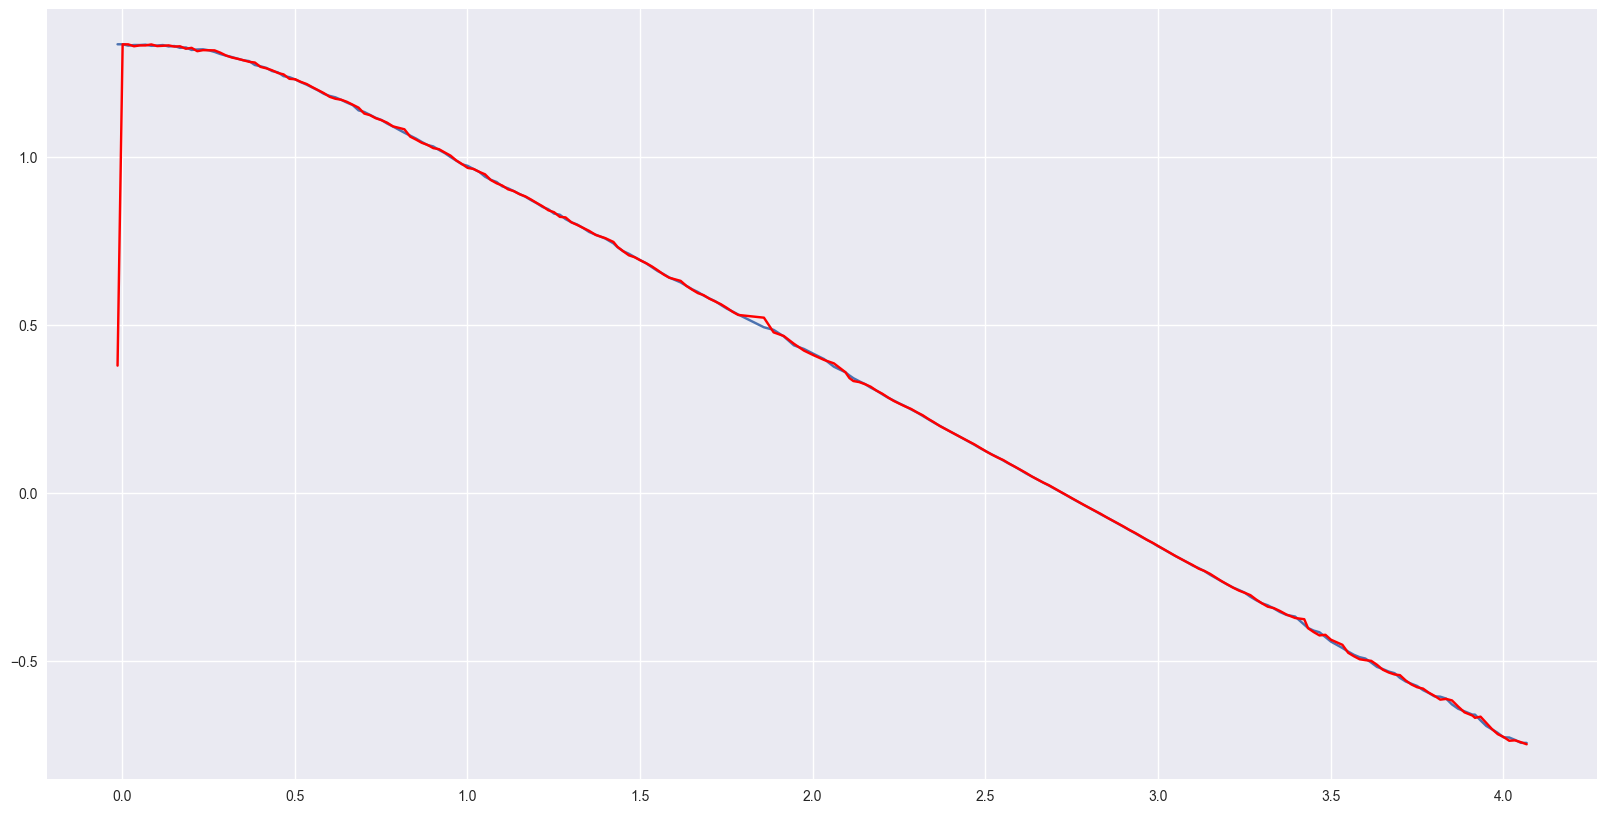

In [145]:
# fit arima model to the tx with respect to time
ego_bev_tx = ego_bev_right_df["tx"]
ego_bev_tx.index = ego_bev_right_df["time_norm (sec)"]
tx_arima_model = sm.tsa.ARIMA(ego_bev_tx, order=(4, 0, 0)).fit()
print(tx_arima_model.summary())

# plot the predicted values
plt.figure(figsize=(20, 10))
plt.plot(ego_bev_tx)
plt.plot(tx_arima_model.fittedvalues, color='red')

<AxesSubplot: xlabel='time_norm (sec)', ylabel='tx'>

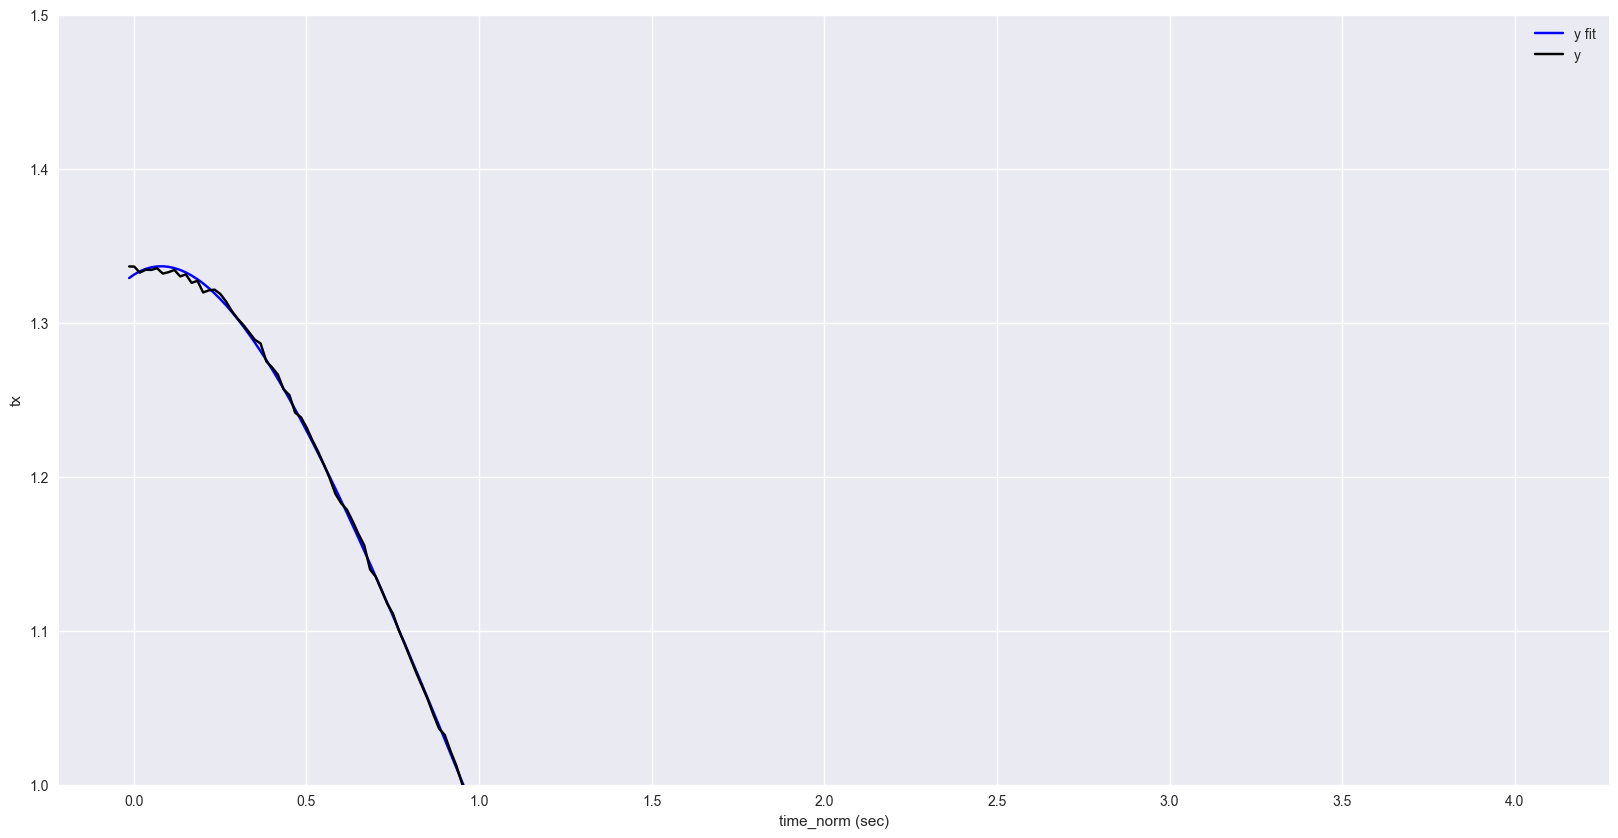

In [106]:
plt.figure(figsize=(20, 10))
# set y limits for the plots
plt.ylim(1, 1.5)

plt.plot(x, model_tx.predict(xp), label='y fit', markersize='5', color='blue')
sns.lineplot(data=ego_bev_right_df, x='time_norm (sec)', y='tx', label='y', color='black')

In [50]:
from numpy.polynomial.polynomial import Polynomial

degree = 3
CONFIDENCE_INTERVAL = 0.95

tx_model: Polynomial = Polynomial.fit(ego_bev_right_df['time_norm (sec)'], ego_bev_right_df['tx'], degree)
ty_model: Polynomial = Polynomial.fit(ego_bev_right_df['time_norm (sec)'], ego_bev_right_df['ty'], degree)
tz_model: Polynomial = Polynomial.fit(ego_bev_right_df['time_norm (sec)'], ego_bev_right_df['tz'], 1)

In [51]:
tz_model.coef

array([ 2.93469373, -0.0100576 ])

In [52]:
tx_preds = tx_model(ego_bev_right_df['time_norm (sec)'])
ty_preds = ty_model(ego_bev_right_df['time_norm (sec)'])
tz_preds = tz_model(ego_bev_right_df['time_norm (sec)'])

tx_residuals = ego_bev_right_df['tx'] - tx_preds
ty_residuals = ego_bev_right_df['ty'] - ty_preds
tz_residuals = ego_bev_right_df['tz'] - tz_preds

# Standard error of the residuals
tx_se = np.sqrt(sum(tx_residuals ** 2) / (len(tx_residuals) - degree - 1))
ty_se = np.sqrt(sum(ty_residuals ** 2) / (len(ty_residuals) - degree - 1))
tz_se = np.sqrt(sum(tz_residuals ** 2) / (len(tz_residuals) - degree - 1))

z_score = stats.norm.ppf(1 - (1 - CONFIDENCE_INTERVAL) / 2)

# (tx_residuals.sum() / (len(tx_residuals) - degree-1))
# tx_se = np.std(tx_residuals)

tx_confidence = z_score * tx_se
ty_confidence = z_score * ty_se
tz_confidence = z_score * tz_se

tx_confidence, ty_confidence, tz_confidence

(0.029075969456155742, 0.02197020341373299, 0.02679651468049569)

<AxesSubplot: xlabel='time_norm (sec)', ylabel='tz'>

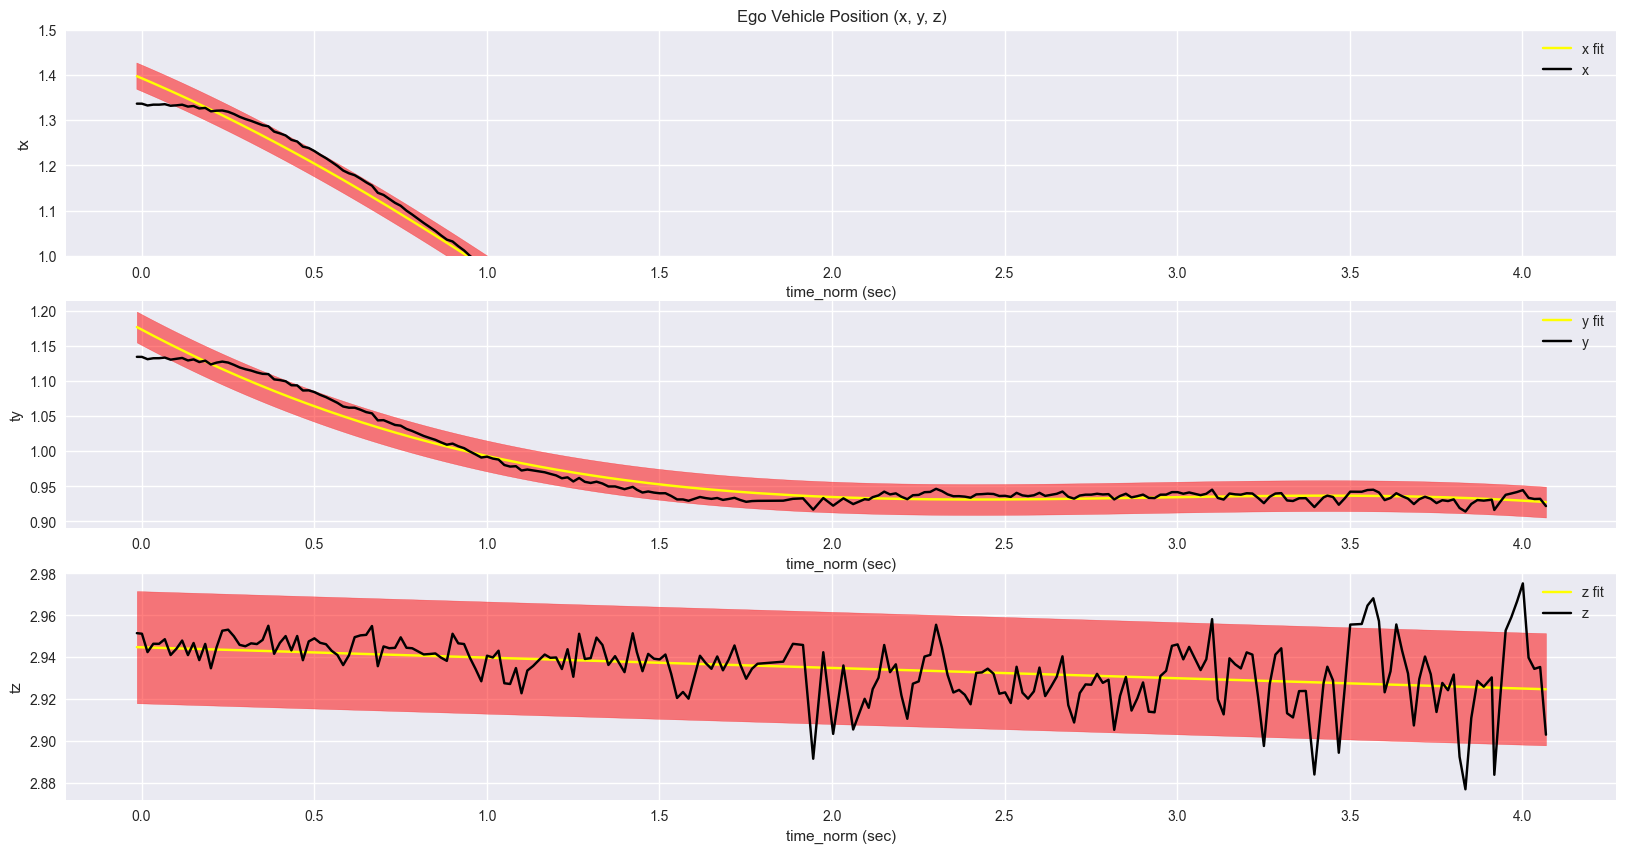

In [53]:
# plot the x and y positions
plt.figure(figsize=(20, 10))

ax = plt.subplot(3, 1, 1)
plt.title('Ego Vehicle Position (x, y, z)')
# ax.set_ylim(1.0, 1.5)
# plot the polynomial fit
plt.plot(ego_bev_right_df['time_norm (sec)'], tx_preds, label='x fit', markersize='5', color='yellow')
# show the confidence interval
plt.fill_between(ego_bev_right_df['time_norm (sec)'], tx_preds - tx_confidence, 
                    tx_preds + tx_confidence, alpha=0.5, color='red')
sns.lineplot(data=ego_bev_right_df, x='time_norm (sec)', y='tx', label='x', color='black')

plt.subplot(3, 1, 2)
plt.plot(ego_bev_right_df['time_norm (sec)'], ty_preds, label='y fit', markersize='5', color='yellow')
plt.fill_between(ego_bev_right_df['time_norm (sec)'], ty_preds - ty_confidence, 
                 ty_preds + ty_confidence, alpha=0.5, color='red')
sns.lineplot(data=ego_bev_right_df, x='time_norm (sec)', y='ty', label='y', color='black')

plt.subplot(3, 1, 3)
plt.plot(ego_bev_right_df['time_norm (sec)'], tz_preds, label='z fit', markersize='5', color='yellow')
plt.fill_between(ego_bev_right_df['time_norm (sec)'], tz_preds - tz_confidence, 
                 tz_preds + tz_confidence, alpha=0.5, color='red')
sns.lineplot(data=ego_bev_right_df, x='time_norm (sec)', y='tz', label='z', color='black')

<AxesSubplot: xlabel='time_norm (sec)', ylabel='tz'>

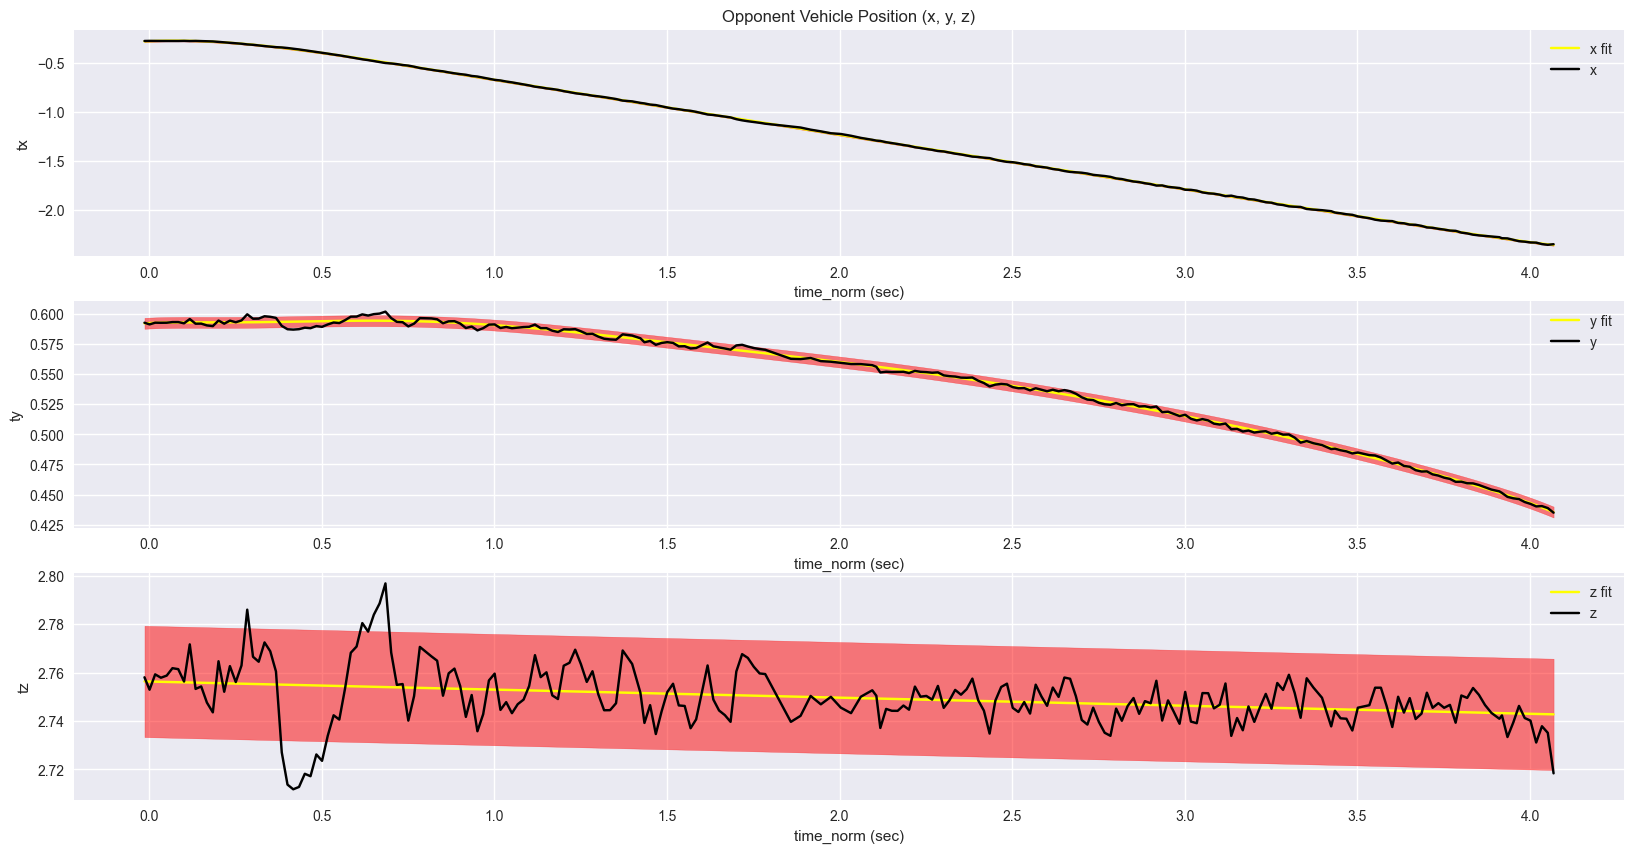

In [111]:
# plot the same for opp_bev_df
tx_model_opp: Polynomial = Polynomial.fit(opp_bev_right_df['time_norm (sec)'], opp_bev_right_df['tx'], degree)
ty_model_opp: Polynomial = Polynomial.fit(opp_bev_right_df['time_norm (sec)'], opp_bev_right_df['ty'], degree)
tz_model_opp: Polynomial = Polynomial.fit(opp_bev_right_df['time_norm (sec)'], opp_bev_right_df['tz'], 1)

tx_preds_opp = tx_model_opp(opp_bev_right_df['time_norm (sec)'])
ty_preds_opp = ty_model_opp(opp_bev_right_df['time_norm (sec)'])
tz_preds_opp = tz_model_opp(opp_bev_right_df['time_norm (sec)'])

tx_residuals_opp = opp_bev_right_df['tx'] - tx_preds_opp
ty_residuals_opp = opp_bev_right_df['ty'] - ty_preds_opp
tz_residuals_opp = opp_bev_right_df['tz'] - tz_preds_opp

tx_se_opp = np.sqrt(sum(tx_residuals_opp ** 2) / (len(tx_residuals_opp) - degree - 1))
ty_se_opp = np.sqrt(sum(ty_residuals_opp ** 2) / (len(ty_residuals_opp) - degree - 1))
tz_se_opp = np.sqrt(sum(tz_residuals_opp ** 2) / (len(tz_residuals_opp) - degree - 1))

tx_confidence_opp = z_score * tx_se_opp
ty_confidence_opp = z_score * ty_se_opp
tz_confidence_opp = z_score * tz_se_opp

plt.figure(figsize=(20, 10))

plt.subplot(3, 1, 1)
plt.title('Opponent Vehicle Position (x, y, z)')
plt.plot(opp_bev_right_df['time_norm (sec)'], tx_preds_opp, label='x fit', markersize='5', color='yellow')

plt.fill_between(opp_bev_right_df['time_norm (sec)'], tx_preds_opp - tx_confidence_opp,
                  tx_preds_opp + tx_confidence_opp, alpha=0.5, color='red')
sns.lineplot(data=opp_bev_right_df, x='time_norm (sec)', y='tx', label='x', color='black')

plt.subplot(3, 1, 2)
plt.plot(opp_bev_right_df['time_norm (sec)'], ty_preds_opp, label='y fit', markersize='5', color='yellow')
plt.fill_between(opp_bev_right_df['time_norm (sec)'], ty_preds_opp - ty_confidence_opp,
                 ty_preds_opp + ty_confidence_opp, alpha=0.5, color='red')
sns.lineplot(data=opp_bev_right_df, x='time_norm (sec)', y='ty', label='y', color='black')

plt.subplot(3, 1, 3)
plt.plot(opp_bev_right_df['time_norm (sec)'], tz_preds_opp, label='z fit', markersize='5', color='yellow')
plt.fill_between(opp_bev_right_df['time_norm (sec)'], tz_preds_opp - tz_confidence_opp,
                 tz_preds_opp + tz_confidence_opp, alpha=0.5, color='red')
sns.lineplot(data=opp_bev_right_df, x='time_norm (sec)', y='tz', label='z', color='black')

<AxesSubplot: xlabel='time_norm (sec)', ylabel='yaw'>

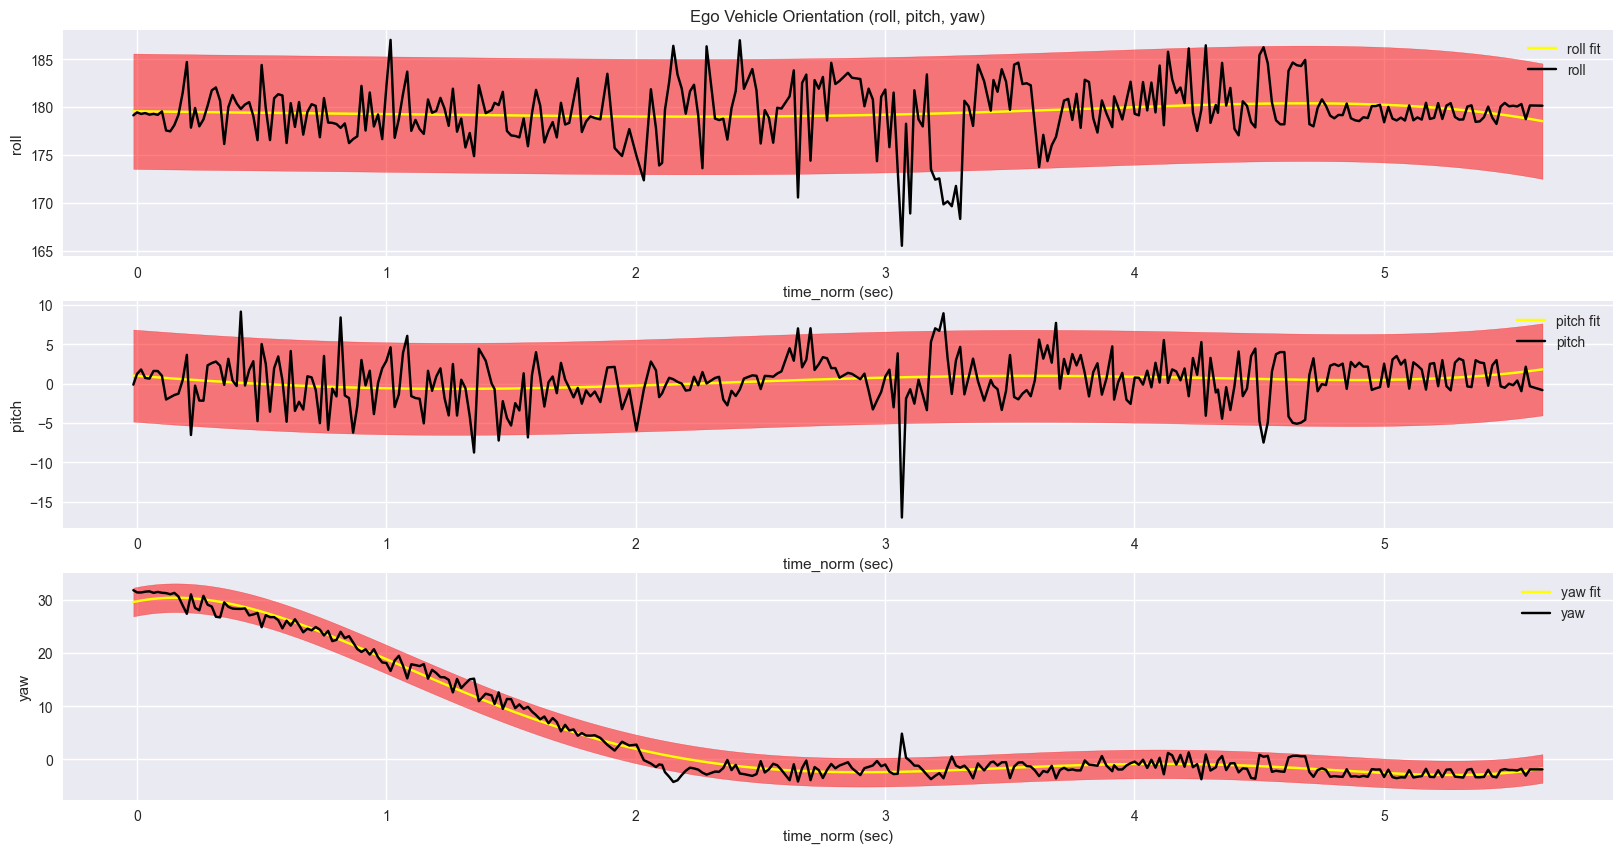

In [25]:
# plot the euler angles of ego_bev_df in the same way
degree = 5
roll_model: Polynomial = Polynomial.fit(ego_bev_right_df['time_norm (sec)'], ego_bev_right_df['roll'], degree)
pitch_model: Polynomial = Polynomial.fit(ego_bev_right_df['time_norm (sec)'], ego_bev_right_df['pitch'], degree)
yaw_model: Polynomial = Polynomial.fit(ego_bev_right_df['time_norm (sec)'], ego_bev_right_df['yaw'], degree)

roll_preds = roll_model(ego_bev_right_df['time_norm (sec)'])
pitch_preds = pitch_model(ego_bev_right_df['time_norm (sec)'])
yaw_preds = yaw_model(ego_bev_right_df['time_norm (sec)'])

roll_residuals = ego_bev_right_df['roll'] - roll_preds
pitch_residuals = ego_bev_right_df['pitch'] - pitch_preds
yaw_residuals = ego_bev_right_df['yaw'] - yaw_preds

roll_se = np.sqrt(sum(roll_residuals ** 2) / (len(roll_residuals) - degree - 1))
pitch_se = np.sqrt(sum(pitch_residuals ** 2) / (len(pitch_residuals) - degree - 1))
yaw_se = np.sqrt(sum(yaw_residuals ** 2) / (len(yaw_residuals) - degree - 1))

z_score = stats.norm.ppf(1 - (1 - CONFIDENCE_INTERVAL) / 2)

roll_confidence = z_score * roll_se
pitch_confidence = z_score * pitch_se
yaw_confidence = z_score * yaw_se

plt.figure(figsize=(20, 10))

plt.subplot(3, 1, 1)
plt.title('Ego Vehicle Orientation (roll, pitch, yaw)')
# plot the polynomial fit
plt.plot(ego_bev_right_df['time_norm (sec)'], roll_preds, label='roll fit', markersize='5', color='yellow')
# show the confidence interval
plt.fill_between(ego_bev_right_df['time_norm (sec)'], roll_preds - roll_confidence, 
                    roll_preds + roll_confidence, alpha=0.5, color='red')
sns.lineplot(data=ego_bev_right_df, x='time_norm (sec)', y='roll', label='roll', color='black')

plt.subplot(3, 1, 2)
plt.plot(ego_bev_right_df['time_norm (sec)'], pitch_preds, label='pitch fit', markersize='5', color='yellow')
plt.fill_between(ego_bev_right_df['time_norm (sec)'], pitch_preds - pitch_confidence, 
                 pitch_preds + pitch_confidence, alpha=0.5, color='red')

sns.lineplot(data=ego_bev_right_df, x='time_norm (sec)', y='pitch', label='pitch', color='black')

plt.subplot(3, 1, 3)
plt.plot(ego_bev_right_df['time_norm (sec)'], yaw_preds, label='yaw fit', markersize='5', color='yellow')
plt.fill_between(ego_bev_right_df['time_norm (sec)'], yaw_preds - yaw_confidence, 
                 yaw_preds + yaw_confidence, alpha=0.5, color='red')

sns.lineplot(data=ego_bev_right_df, x='time_norm (sec)', y='yaw', label='yaw', color='black')

In [45]:
ego_bev_right_df[ego_bev_right_df["rel_x"]]

KeyError: 'rel_x'

[[700.67498779   0.         628.23999023]
 [  0.         700.67498779 350.07598877]
 [  0.           0.           1.        ]] [[541.27227994   0.         623.99757244]
 [  0.         539.36284999 348.98083539]
 [  0.           0.           1.        ]]
(array([[[568.90155, 479.27914],
        [538.7743 , 477.79434],
        [540.32275, 448.13922],
        [569.1772 , 449.3395 ]]], dtype=float32), array([[[853.818  , 530.2276 ],
        [878.7594 , 542.9899 ],
        [865.7583 , 567.4287 ],
        [841.1407 , 554.71765]]], dtype=float32))
[14] [[-0.34940086]
 [ 0.57701142]
 [ 2.71810915]] (-155.22822440140925, 17.219185996796707, -173.52667522433208)
[14] [[-0.35008119]
 [ 0.57762453]
 [ 2.71732378]] (-179.59745321141247, -4.260369315475298, -178.3226847529708)

[12] [[1.274891  ]
 [1.08410769]
 [2.92564755]] (-179.30245326546014, 0.4887005447491541, 27.22340293266063)
[12] [[1.27368055]
 [1.08302525]
 [2.92568723]] (158.39867259741553, 56.611848363388624, 15.939286867812388)

[[700.

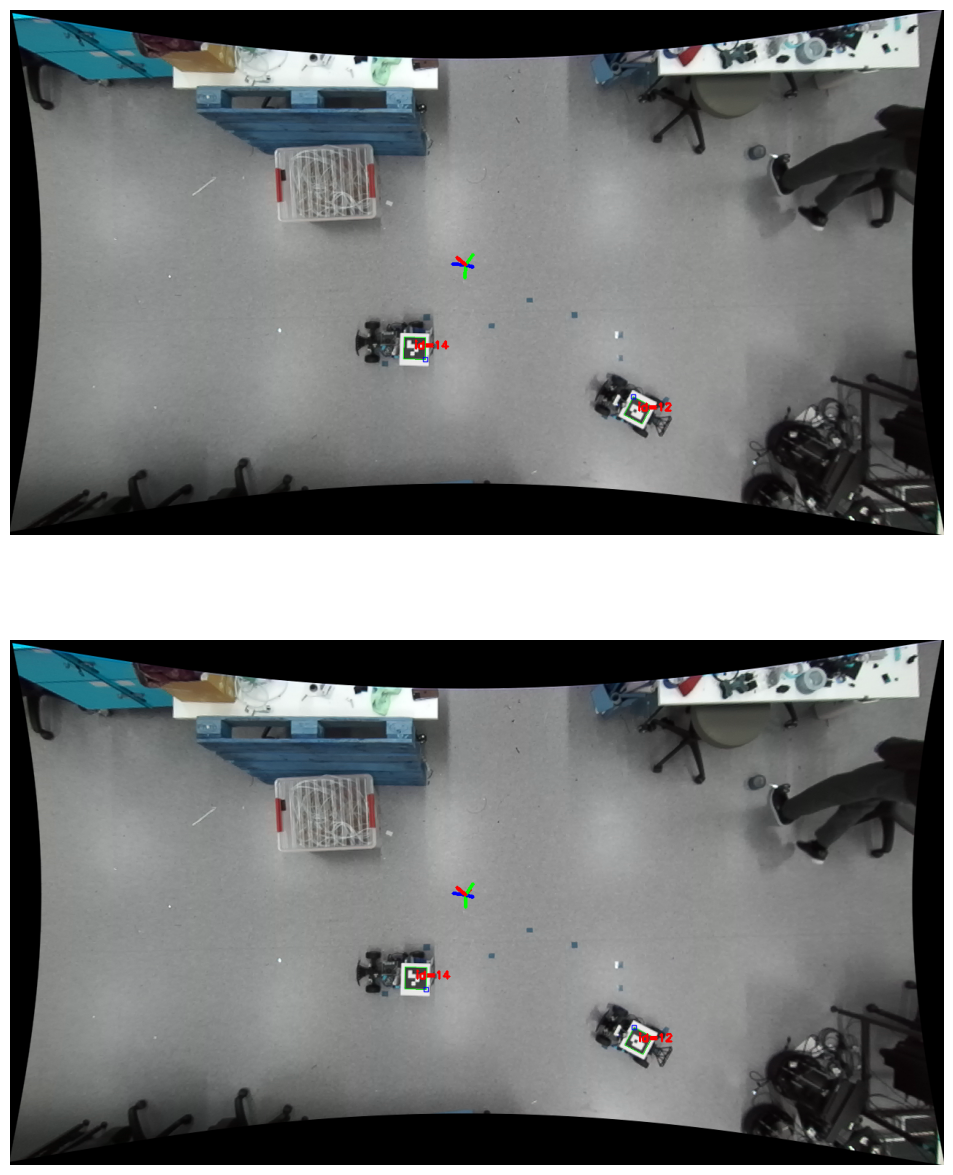

In [45]:
import perception.util.aruco as aruco

num = 26
image_prev = cv2.imread(f'{run1_data[run_num]["bev_path"]}/bev/right/{ego_bev_right_df["time"].iloc[num - 1]}.png')

image = cv2.imread(f'{run1_data[run_num]["bev_path"]}/bev/right/{ego_bev_right_df["time"].iloc[num]}.png')
# image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

intrinsics = np.loadtxt(f'{run1_data[6]["bev_path"]}/bev/right/intrinsics.txt')
dist_coeffs = np.loadtxt(f'{run1_data[6]["bev_path"]}/bev/right/dist_coeffs.txt')
detector_params = cv2.aruco.DetectorParameters()
detector_params.cornerRefinementMethod = cv2.aruco.CORNER_REFINE_APRILTAG
# detector_params.cornerRefinementMinAccuracy = 0.1
def draw_markers_on_image(image, intrinsics, dist_coeffs):
  new_intrinsics, _ = cv2.getOptimalNewCameraMatrix(intrinsics, dist_coeffs, (image.shape[1], image.shape[0]), 1)
  undistorted_image = cv2.undistort(image, intrinsics, dist_coeffs, None, new_intrinsics)
  print(intrinsics, new_intrinsics)
  und_corners, und_ids, _ = cv2.aruco.detectMarkers(undistorted_image, dictionary, parameters=detector_params)
  print(und_corners)

  drawn_image = cv2.aruco.drawDetectedMarkers(undistorted_image.copy(), und_corners, und_ids)

  for corner, id in zip(und_corners, und_ids):
    _, rvecs_und, tvecs_und, reproj_error = cv2.solvePnPGeneric(marker_obj_points, corner, new_intrinsics, None, flags=cv2.SOLVEPNP_IPPE_SQUARE)
    for rvec_und, tvec_und in zip(rvecs_und, tvecs_und):
      # rvec_und = conv.get_rodrigues_from_euler(45,0,0, degrees=True)
      # rvec_und = conv.get_rodrigues_from_euler(20, 20, 20, degrees=True)
      quat = conv.get_quaternion_from_rodrigues(rvec_und)
      euler_und = conv.get_euler_from_quaternion(*quat, degrees=True)
      print(id, tvec_und, euler_und)
    
    print("")
    tvec_und = np.array([0, 0, 3], dtype=np.float32)
    cv2.drawFrameAxes(drawn_image, new_intrinsics, None, rvec_und, tvec_und, 0.1)
  
  return drawn_image

drawn_image = draw_markers_on_image(image, intrinsics, dist_coeffs)
drawn_image_prev = draw_markers_on_image(image_prev, intrinsics, dist_coeffs)

plt.figure(figsize=(20, 15))
plt.subplot(2, 1, 1)
plt.grid(False)
plt.axis('off')
plt.imshow(drawn_image)

plt.subplot(2, 1, 2)
plt.grid(False)
plt.axis('off')
plt.imshow(drawn_image_prev)